# Bias-Aware Clustering
In this notebook, we experiment with the Bias-Aware Clustering algorithm to identify which of the clustering algorithms (K-Means, DBSCAN or MeanShift) perform best in identifying discriminated clusters. The experiment is conducted with the German Credit Risk dataset.

To obtain the appropriate input for the Bias-Aware Clustering algorithm, we have preprocessed the dataset such that:
- It contains the errors obtained from a random forest classifier on the test set.
- The categorical attributes have been one-hot encoded
- We also have the predicted class and true class attributes. If your dataset doesn't contain these columns, please use the "synthetic data" notebook. 

### Init


In [53]:
# Loading the libraries
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from ridgeplot import ridgeplot
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
import warnings
warnings.filterwarnings('ignore')

## 1. Importing the Dataset

In [2]:
# raw_data = pd.read_csv(r'..\Preprocessed_datasets\preprocessed_german_credit.csv', index_col=0)

raw_data = pd.read_csv(r'..\Preprocessed_datasets\preprocessed_wine_final.csv', index_col=0)
features = raw_data.drop(['predicted_class', 'true_class', 'errors'], axis=1)

# Number of errors
# raw_data.loc[raw_data['errors']==1]

# raw_data.head()


In [3]:
dataset = initialize_dataset(raw_data)
dataset.loc[dataset['errors']==1]



NameError: name 'initialize_dataset' is not defined

### Utils
The required functions for Bias-Aware Computing 

In [69]:
def pca_plot(data):
    """ Function to perform dimensionality reduction on the features, so that we can create 2-dimensional scatterplots.
    Takes as input the entire dataset, selects the features on which we want to cluster, and stores them in a temporary pd Dataframe. 
    This df is used to create a seaborn scatterplot. """
    
    pca_features = data.drop(['scaled_errors', 'predicted_class', 'true_class', 'errors', 'clusters', 'new_clusters'], axis=1)
    other_features = data[['scaled_errors', 'predicted_class', 'true_class', 'errors', 'clusters', 'new_clusters']]
    
    df = pd.DataFrame(pca_features)
    pca = pd.DataFrame(PCA(n_components=2).fit_transform(df), index=df.index)
    temp_dataset = pca.join(other_features, how='left')
    temp_dataset.rename( columns={0 :'PCA - 1st'}, inplace=True )
    temp_dataset.rename( columns={1 :'PCA - 2nd'}, inplace=True )

    scatterplot = sns.scatterplot(data=temp_dataset, x='PCA - 1st', y='PCA - 2nd', hue="clusters", size='errors', sizes=(150, 30), palette="tab10")
    scatterplot.set_title('MeanShift clusters in Wine')
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
    # plt.savefig('wine_testdata.png', dpi=300) # for saving a plot
    plt.show()

def initialize_dataset(raw_data, with_errors=True, just_features=True, scale_features=True, with_classes=True):
    """ Initialisation of the dataset. Scales all the features and can also scale the errors, which can be included or excluded for clustering 
    It returns a scaled dataset with new columns "clusters" = 0 and "new_clusters" = -1, which are required for HBAC """

    new_data = raw_data.copy(deep=True)

    if with_errors:
        scaling_factor = 0.8 #needs to be converted to scaling range [0.2 - 1.2]
        new_data['scaled_errors'] = new_data['errors'] * 0.8 

    if just_features:
        new_data = new_data.drop(['predicted_class', 'true_class', 'errors'], axis=1)

    if scale_features:
        to_scale = raw_data.drop(['predicted_class', 'true_class', 'errors'], axis=1).columns
        new_data[to_scale] = StandardScaler().fit_transform(features[to_scale])
    
    if with_classes:
        for col in ['predicted_class', 'true_class', 'errors']:
            new_data[col] = raw_data[col]

    new_data['clusters'] = 0
    new_data['new_clusters'] = -1
    return new_data

def get_random_cluster(clusters):
    ''' This function returns the value of a random cluster
    clusters Df.Column the column clusters '''
    result = -1
    while (result == -1):
        result = random.randint(0, len(clusters.unique()))
    return result

def plot_clusters(data):
    ''' This function returns a scatterplot of the clusters ''' 
    scatterplot = sns.scatterplot(data=data, x='1st', y='2nd', hue="clusters", size='errors', sizes=(100, 20), palette="tab10")
    plt.show()

def accuracy(results):
    ''' This function calculates the accuracy of a DF dataframe
    It requires a df.column named "errors" '''
    if len(results) == 0:
        print("You are calculating the accuracy on a empty cluster") 
    correct = results.loc[results['errors'] == 0]
    acc = len(correct)/len(results)
    return acc

def bias_acc(data, cluster_id, cluster_col):
    ''' This function calculates the negative bias, which is the accuracy of the selected cluster - the accuracy of the remaining clusters 
    Cluster col: the name of the DF column where the cluster assignments are '''
    cluster_x = data.loc[data[cluster_col] == cluster_id]
    if len(cluster_x) ==0:
        print("This is an empty cluster! cluster ", cluster_id)
    remaining_clusters = data.loc[data[cluster_col] != cluster_id]
    if len(remaining_clusters) == 0:
        print("This cluster is the entire dataset. cluster ", cluster_id)
    return accuracy(cluster_x) - accuracy(remaining_clusters)

def bias_acc_towards_global_average(data, cluster_id, cluster_col, ave_acc):
    ''' This function calculates the negative bias, which is the accuracy of the selected cluster - the average accuracy
    Cluster col: the name of the DF column where the cluster assignments are '''
    cluster_x = data.loc[data[cluster_col] == cluster_id]
    return accuracy(cluster_x) - ave_acc

def get_next_cluster(data):
    ''' This function returns the cluster number with the highest variance. The variance is calculated based on the errors of each cluster.
    The cluster with the highest variance will be selected as splitting cluster
    The function requires df.columns named "clusters" and "errors '''
    n_cluster = max(data['clusters'])
    highest_variance = -1
    cluster_number = 0

    for i in data['clusters'].unique():
        if (i == -1):
            continue
        cluster_i = data.loc[data['clusters'] == i]
        variance_cluster = np.var(cluster_i['errors'])
        
        if variance_cluster > highest_variance:
            highest_variance = variance_cluster
            cluster_number = i
            print('--> Cluster with the highest variance:', cluster_number)

    return cluster_number

def get_max_abs_bias(fulldata, function=bias_acc):
    ''' This function returns the absolute value of highest negative bias of the newly introduced clusters 
    fulldata (DataFrame) should include a column new_clusters '''
    max_abs_bias = -999999
    for cluster_number in fulldata['new_clusters'].unique():
        if cluster_number == -1: #Outliers in DBScan
            continue
        current_bias = abs(function(fulldata, cluster_number, "new_clusters")) # abs function
        if current_bias > max_abs_bias:
            max_abs_bias = current_bias
    return max_abs_bias

def get_max_negative_bias(fulldata, function=bias_acc):
    ''' This function returns the highest negative bias of the newly introduced clusters 
    fulldata (DataFrame) should include a column new_clusters  --> used for identifying underperformed clusters '''
    max_abs_bias = -999999
    for cluster_number in fulldata['new_clusters'].unique():
        if cluster_number == -1: #Outliers in DBScan
            continue
        current_bias = (function(fulldata, cluster_number, "new_clusters")) # abs function
        if current_bias < max_abs_bias:
            print('current bias: ', current_bias)
            print('max abs bias: ', max_abs_bias)
            max_abs_bias = current_bias
    return max_abs_bias

def get_max_bias_cluster(fulldata, function=bias_acc):
    ''' This function returns the cluster linked to the highest negative bias of the newly introduced clusters 
    fulldata (DataFrame) should include a column new_clusters '''
    max_abs_bias = 100
    best_cluster = -2
    for cluster_number in fulldata['clusters'].unique():
        if cluster_number == -1: # Outliers in DBScan, which are excluded
            continue
        current_bias = (function(fulldata, cluster_number, "clusters")) # abs function to find the highest bias
        print(f"{cluster_number} has bias {current_bias}")
        if current_bias < max_abs_bias:
            max_abs_bias = current_bias
            best_cluster = cluster_number
    return best_cluster

def calculate_variance(data):
    ''' This function calculates the variance for a DF. It requires a df.column named "clusters" and it uses the bias_acc_towards_global_avg '''
    variance_list_local = []
    for j in data['clusters'].unique():
        average_accuracy = accuracy(data)
        neg_bias_clus = bias_acc(data, j, 'clusters') 
        variance_list_local.append(neg_bias_clus) #variance_list was "neg_bias_list" before
    variance = np.var(variance_list_local) #this was "neg_bias_list"
    return variance

def get_min_cluster_size(data):
    ''' Returns the size of the smallest new cluster '''
    min_cluster_size = len(data)
    for i in data['new_clusters'].unique():
        # exclude the cluster -1 from being seen as a cluster, since it contains outliers
        if i == -1:
            continue
        size = len(full_data.loc[full_data['new_clusters']==i])
        if size < min_cluster_size:
            min_cluster_size = size
    return min_cluster_size

# 1. Bias-Aware KMeans Clustering 

In [54]:
full_data = initialize_dataset(raw_data)
full_data.head()


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,scaled_errors,predicted_class,true_class,errors,clusters,new_clusters
104,-0.669074,-0.481192,-1.166817,0.461386,-0.963795,-0.130285,-0.137723,-0.284577,-0.211402,-1.025689,0.361193,1.354564,-0.225753,0.0,1,1,0,0,-1
67,-0.847070,-0.970763,-1.370315,0.208443,-1.360004,-0.265798,-0.063096,-0.686333,-0.903977,-0.239382,0.710266,1.229242,-0.714467,0.0,1,1,0,0,-1
118,-0.338510,1.005004,-1.166817,-0.803327,-1.246801,-0.988536,-0.762724,0.599286,-1.234524,-0.817815,-1.122366,-0.664518,-1.130778,0.8,2,1,1,0,-1
39,1.505019,1.494574,0.630750,-1.590260,1.470062,1.074278,0.907054,-1.248791,0.733019,-0.049584,-0.293318,1.298865,0.039721,0.0,0,0,0,0,-1
176,0.170050,0.270648,0.155921,0.320862,1.017252,-0.958422,-1.294440,1.402798,-0.242882,1.848400,-1.558707,-1.360753,0.281061,0.0,2,2,0,0,-1


In [6]:
clus_model_kwargs = {
    "n_clusters": 2,
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 10,
}

Minimal splittable cluster size & minimal acceptable cluster size: 5% of the dataset


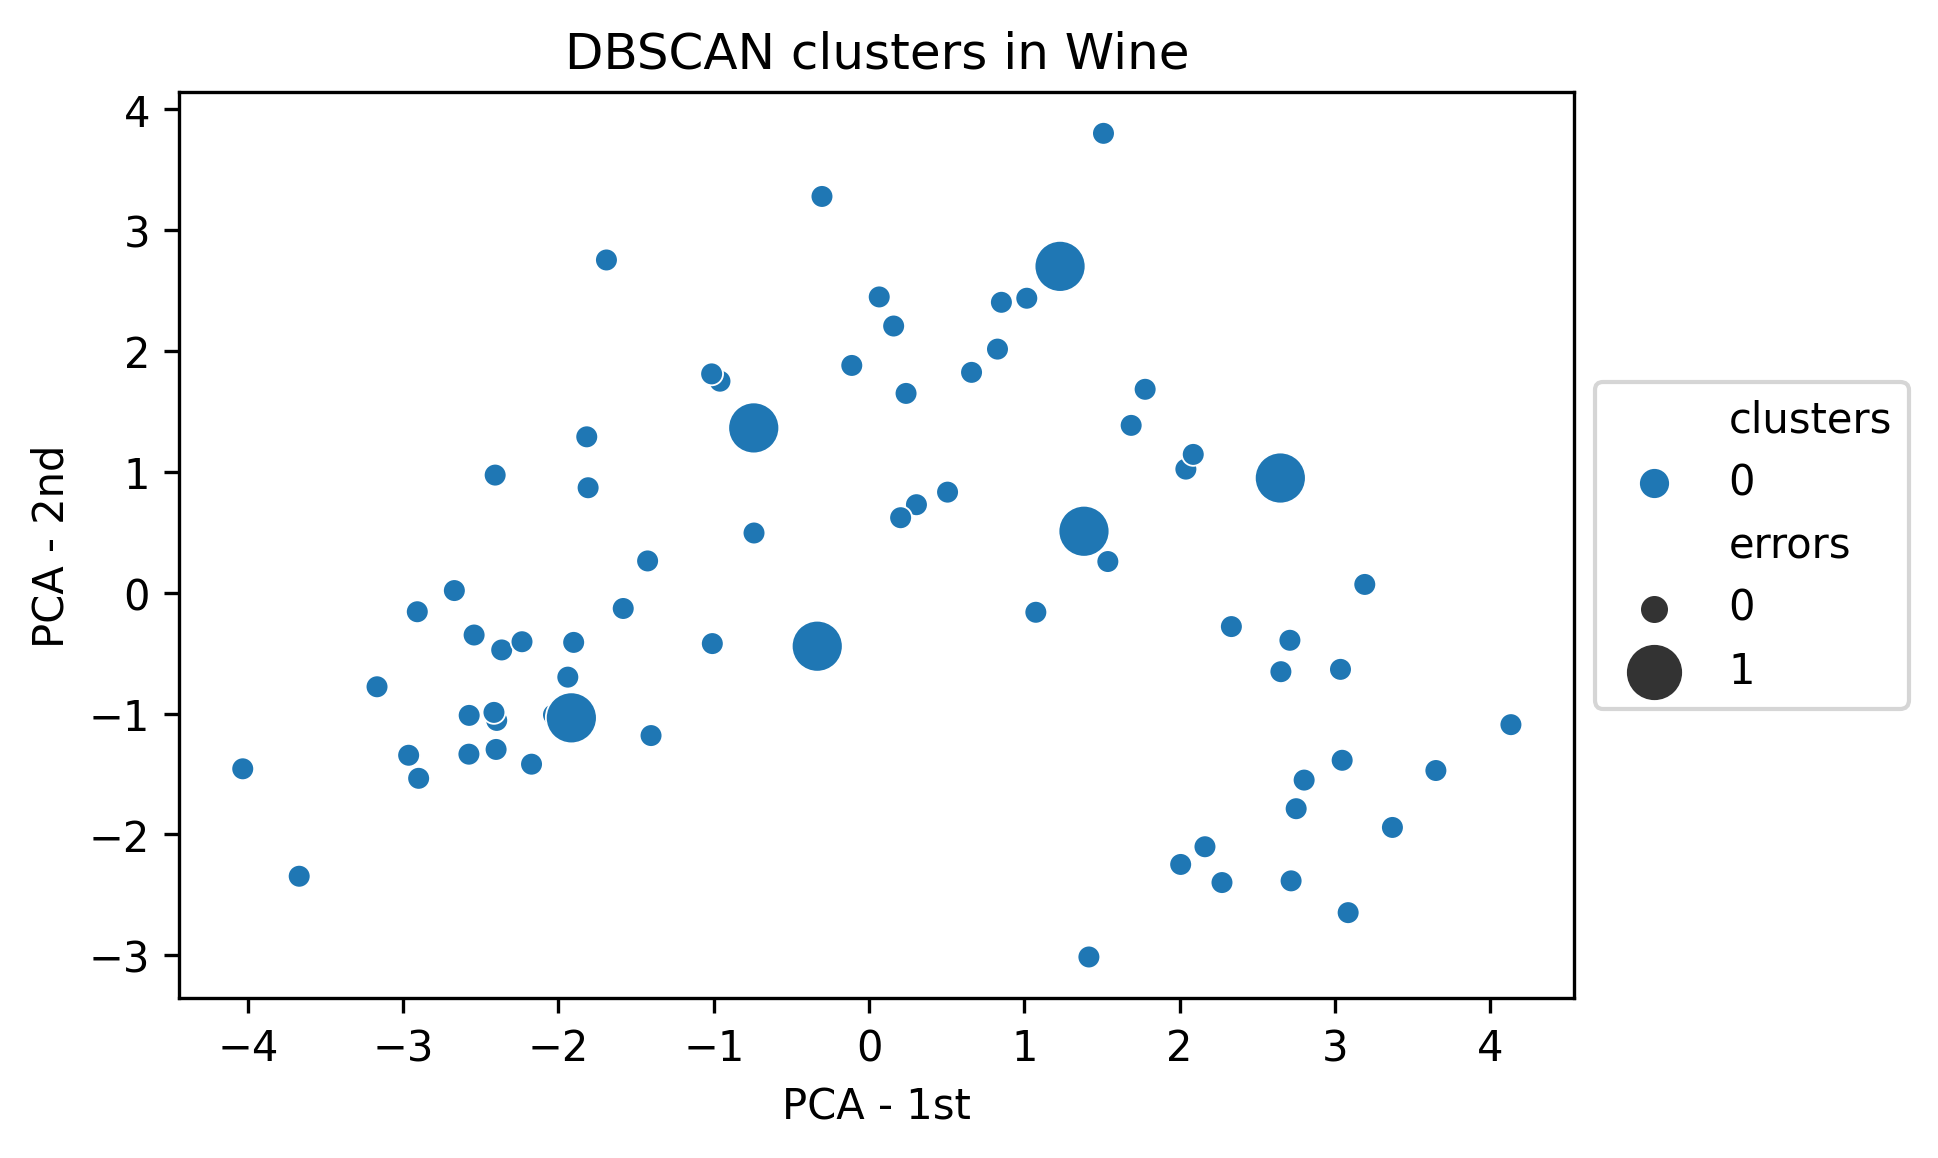

average_accuracy is:  0.9166666666666666


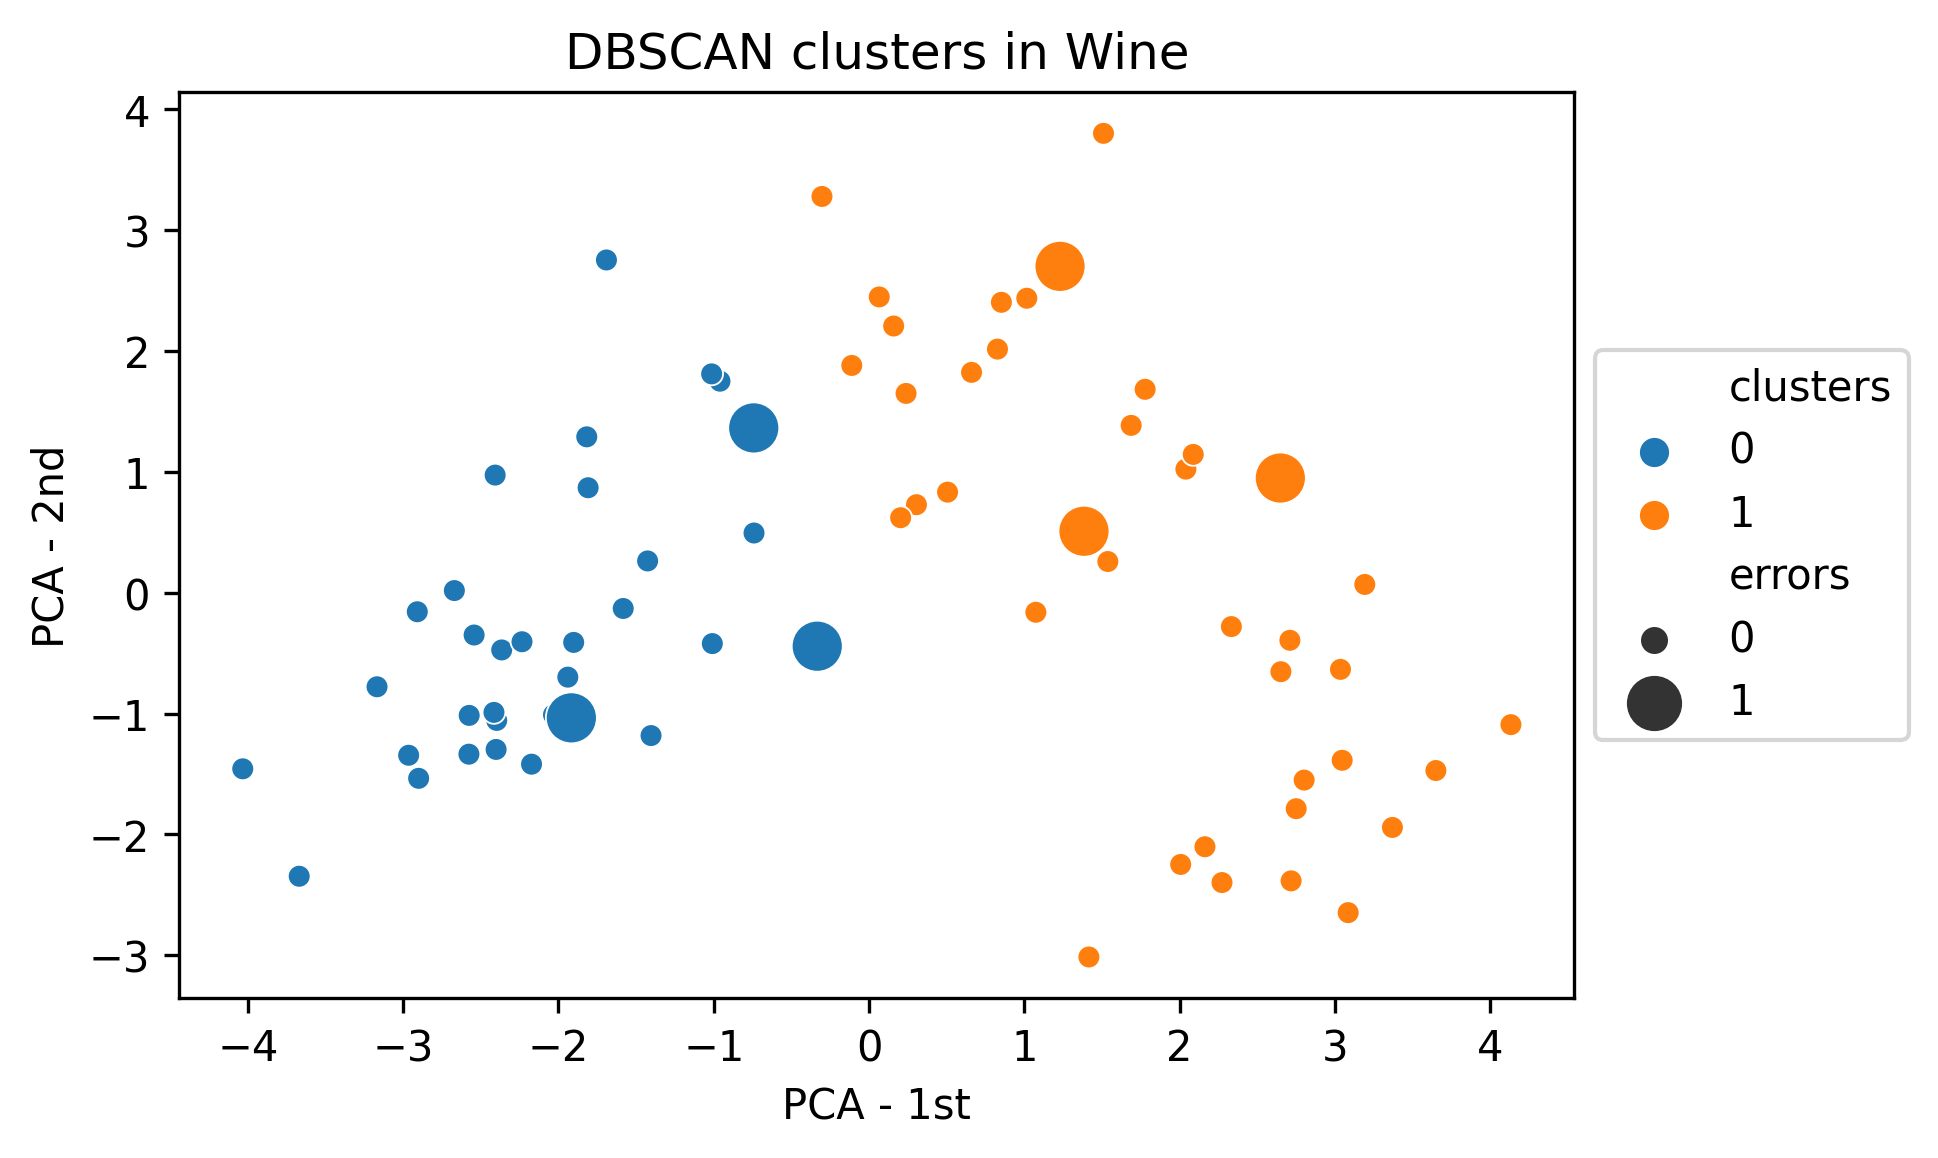

--> Cluster with the highest variance: 1
--> Cluster with the highest variance: 0


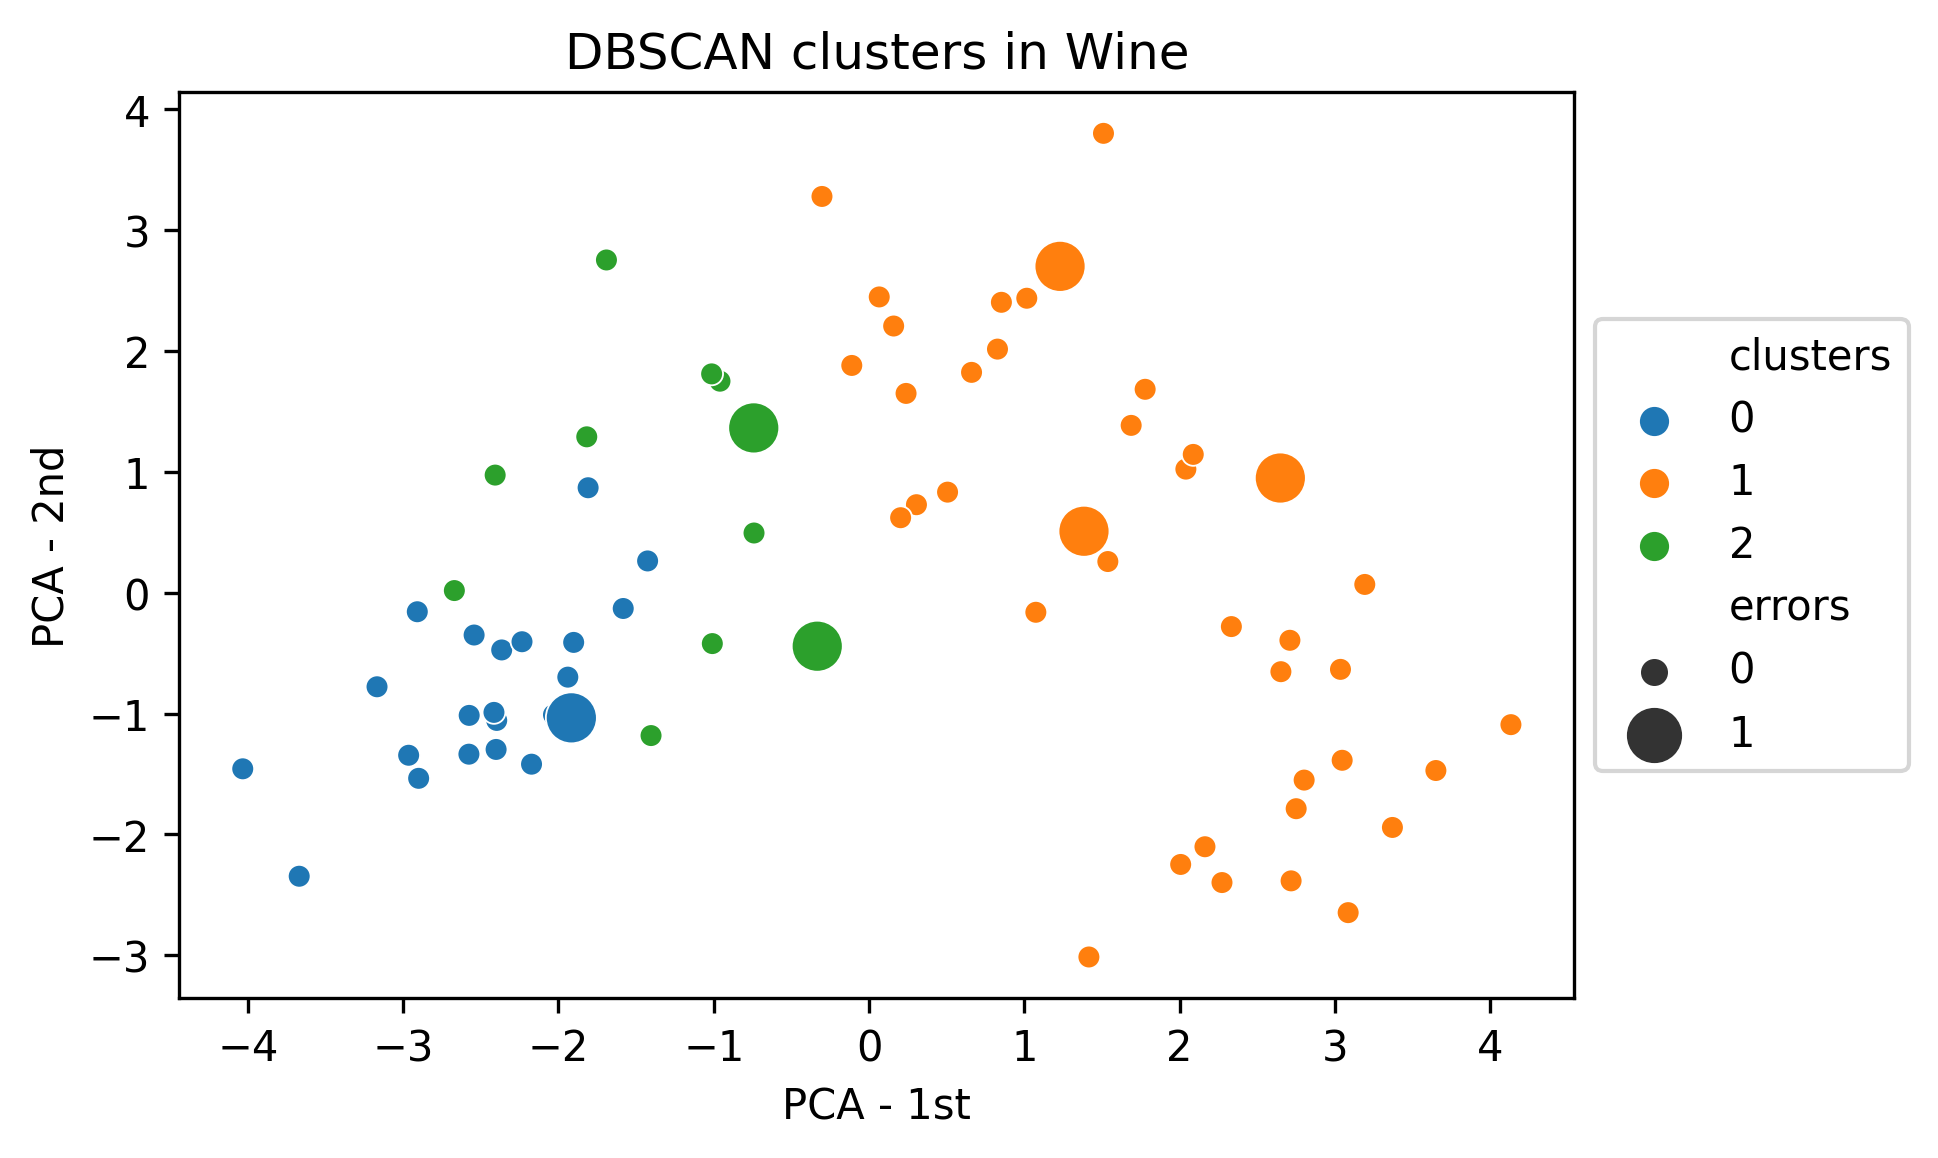

--> Cluster with the highest variance: 1
--> Cluster with the highest variance: 2


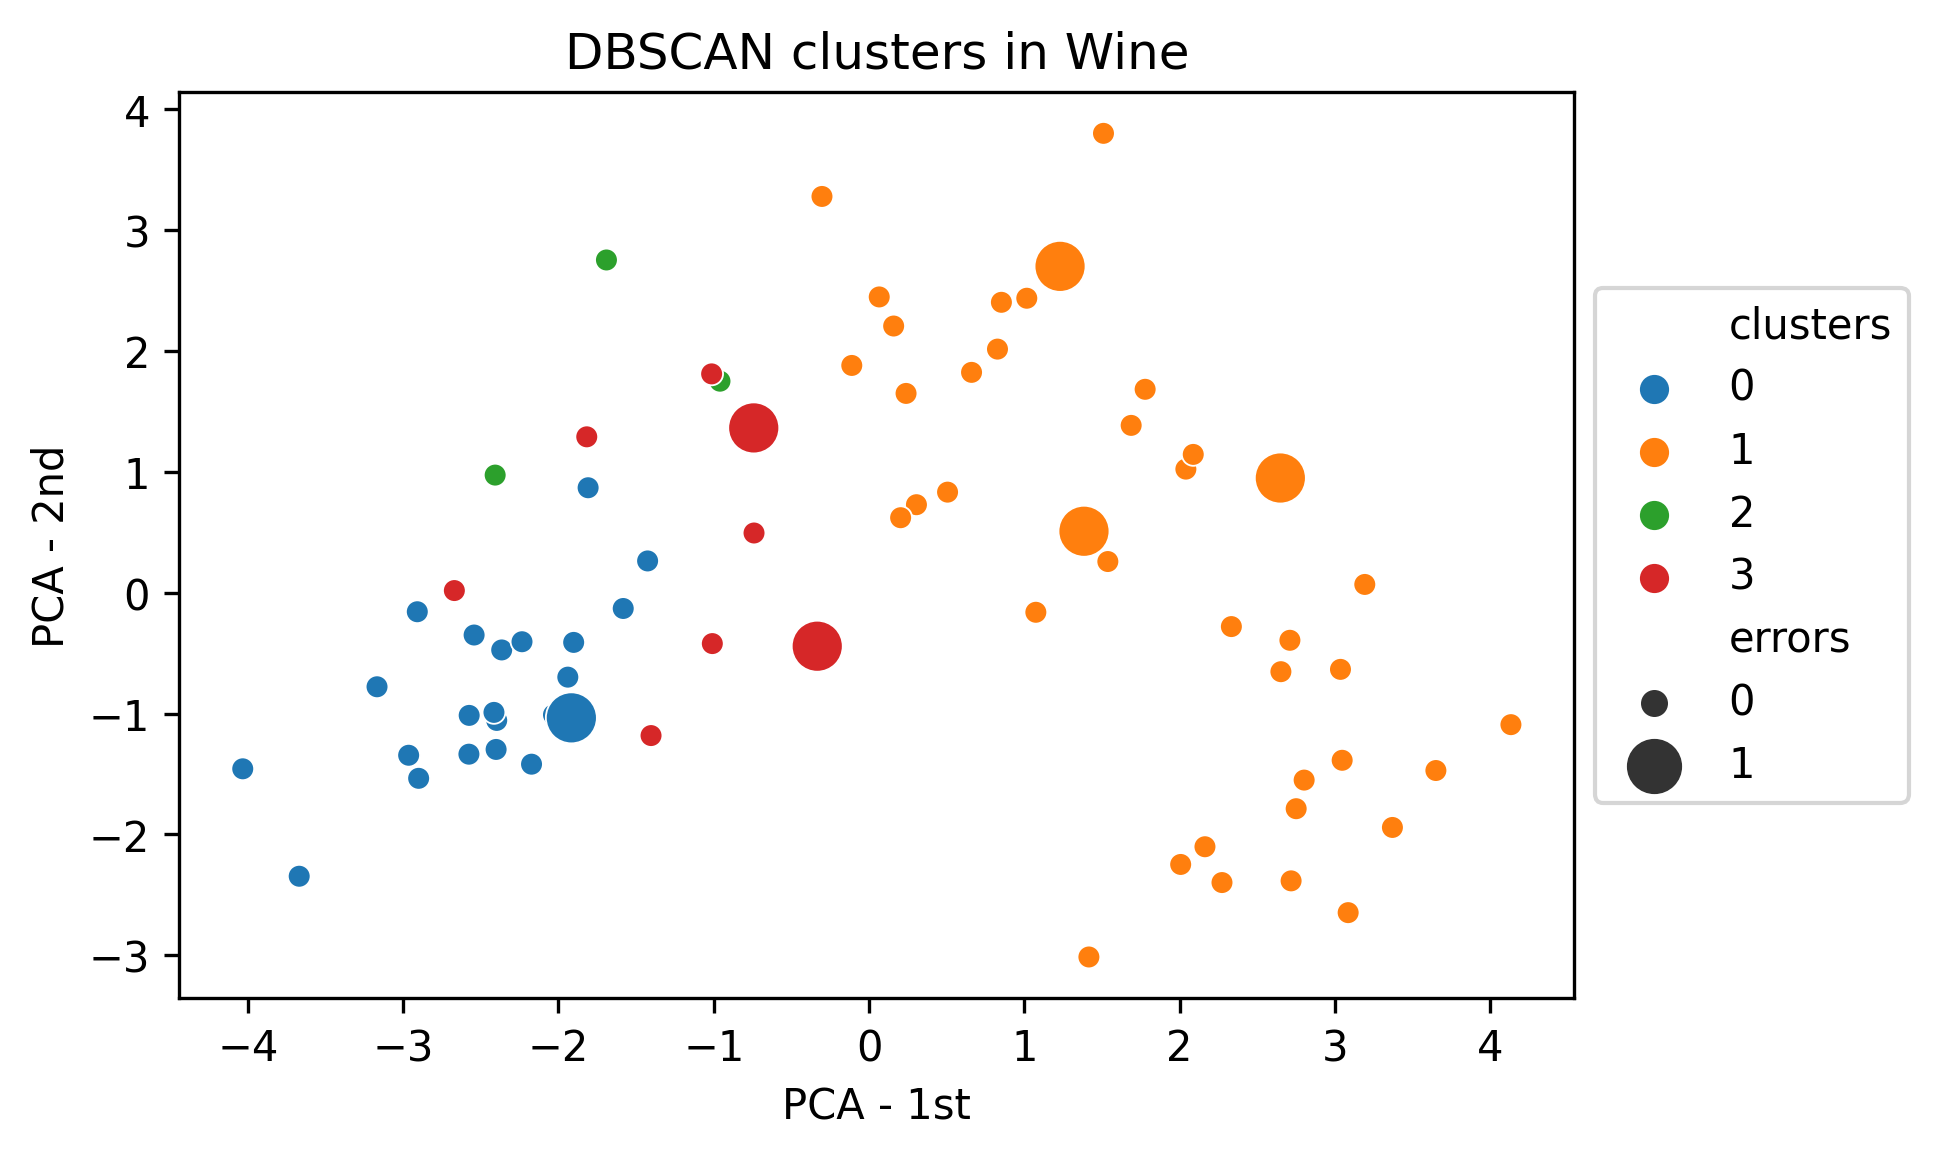

--> Cluster with the highest variance: 1
--> Cluster with the highest variance: 3


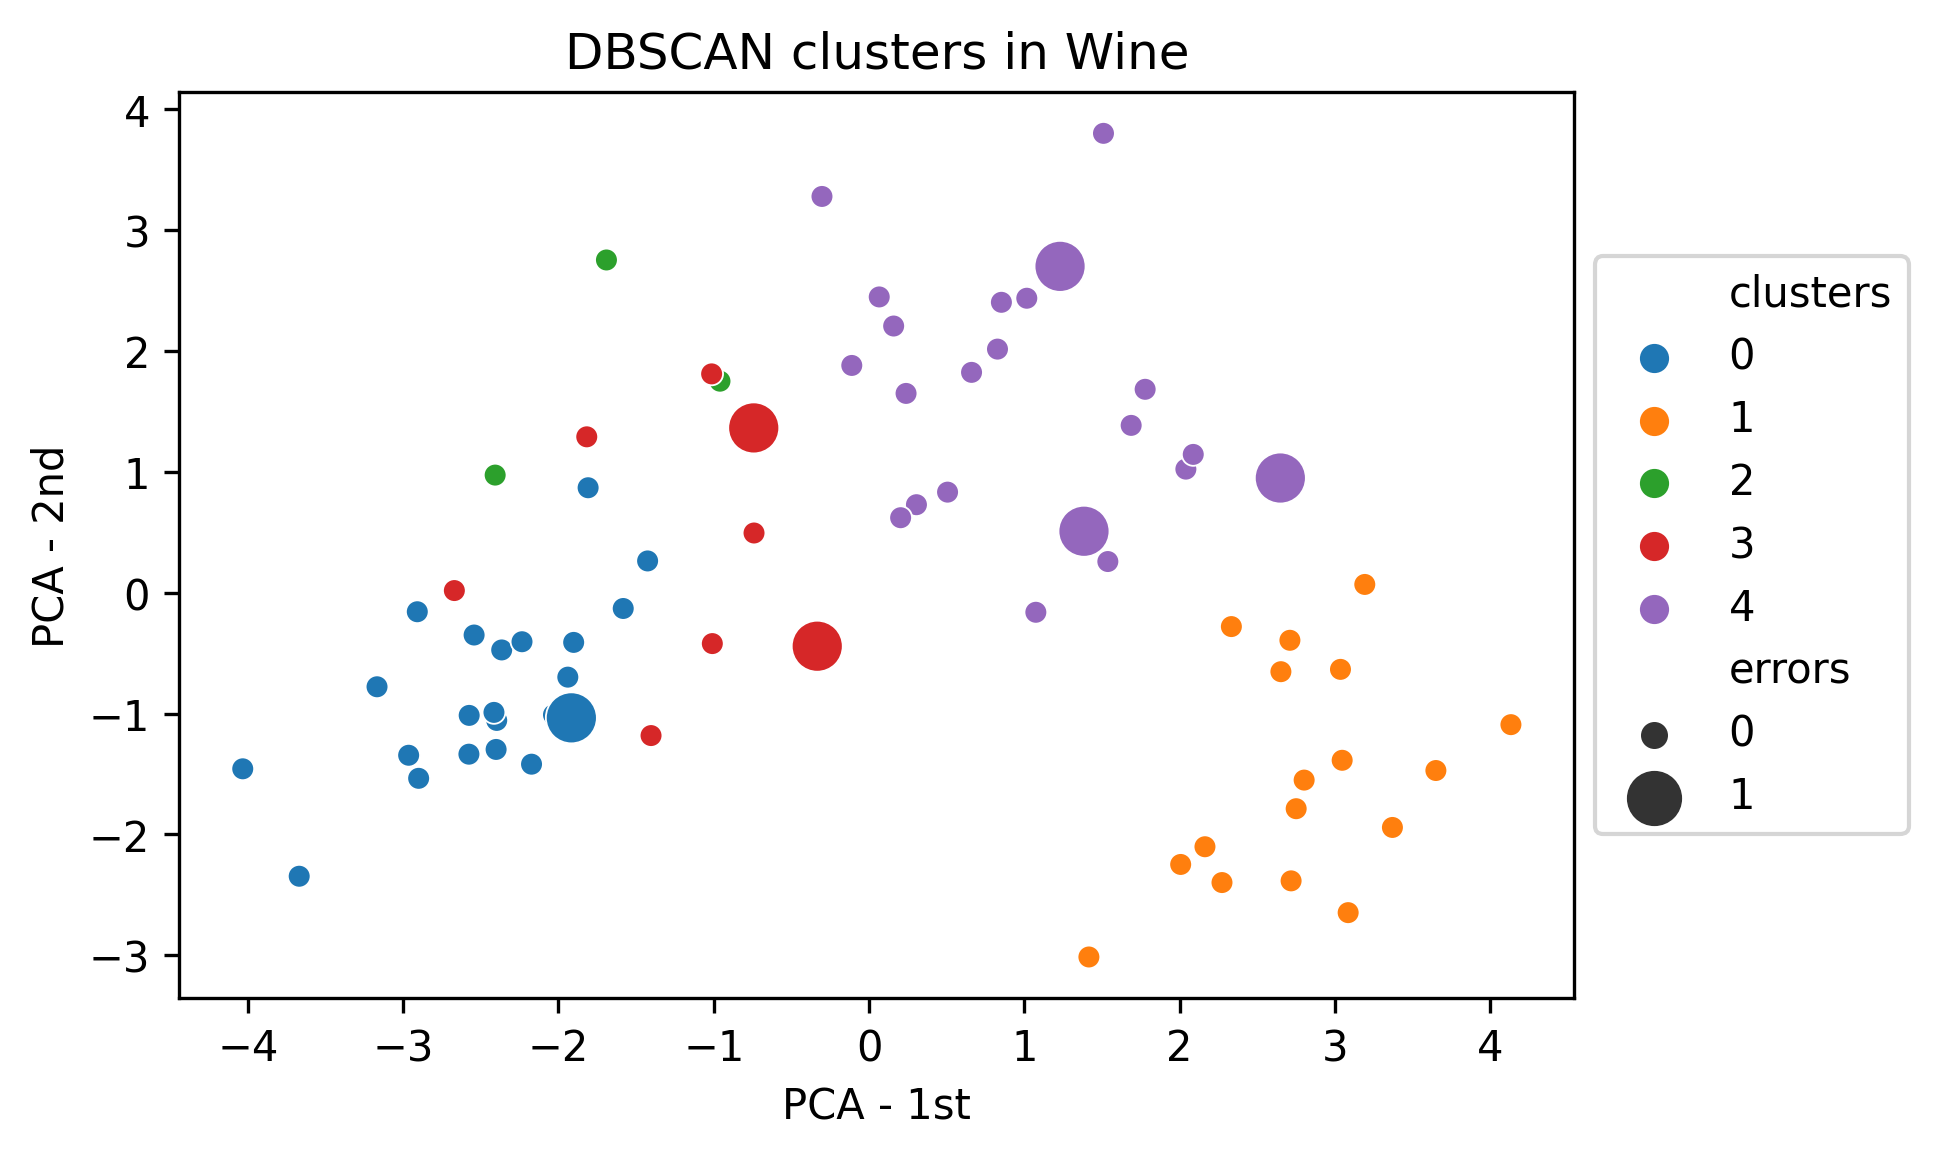

--> Cluster with the highest variance: 4
--> Cluster with the highest variance: 3


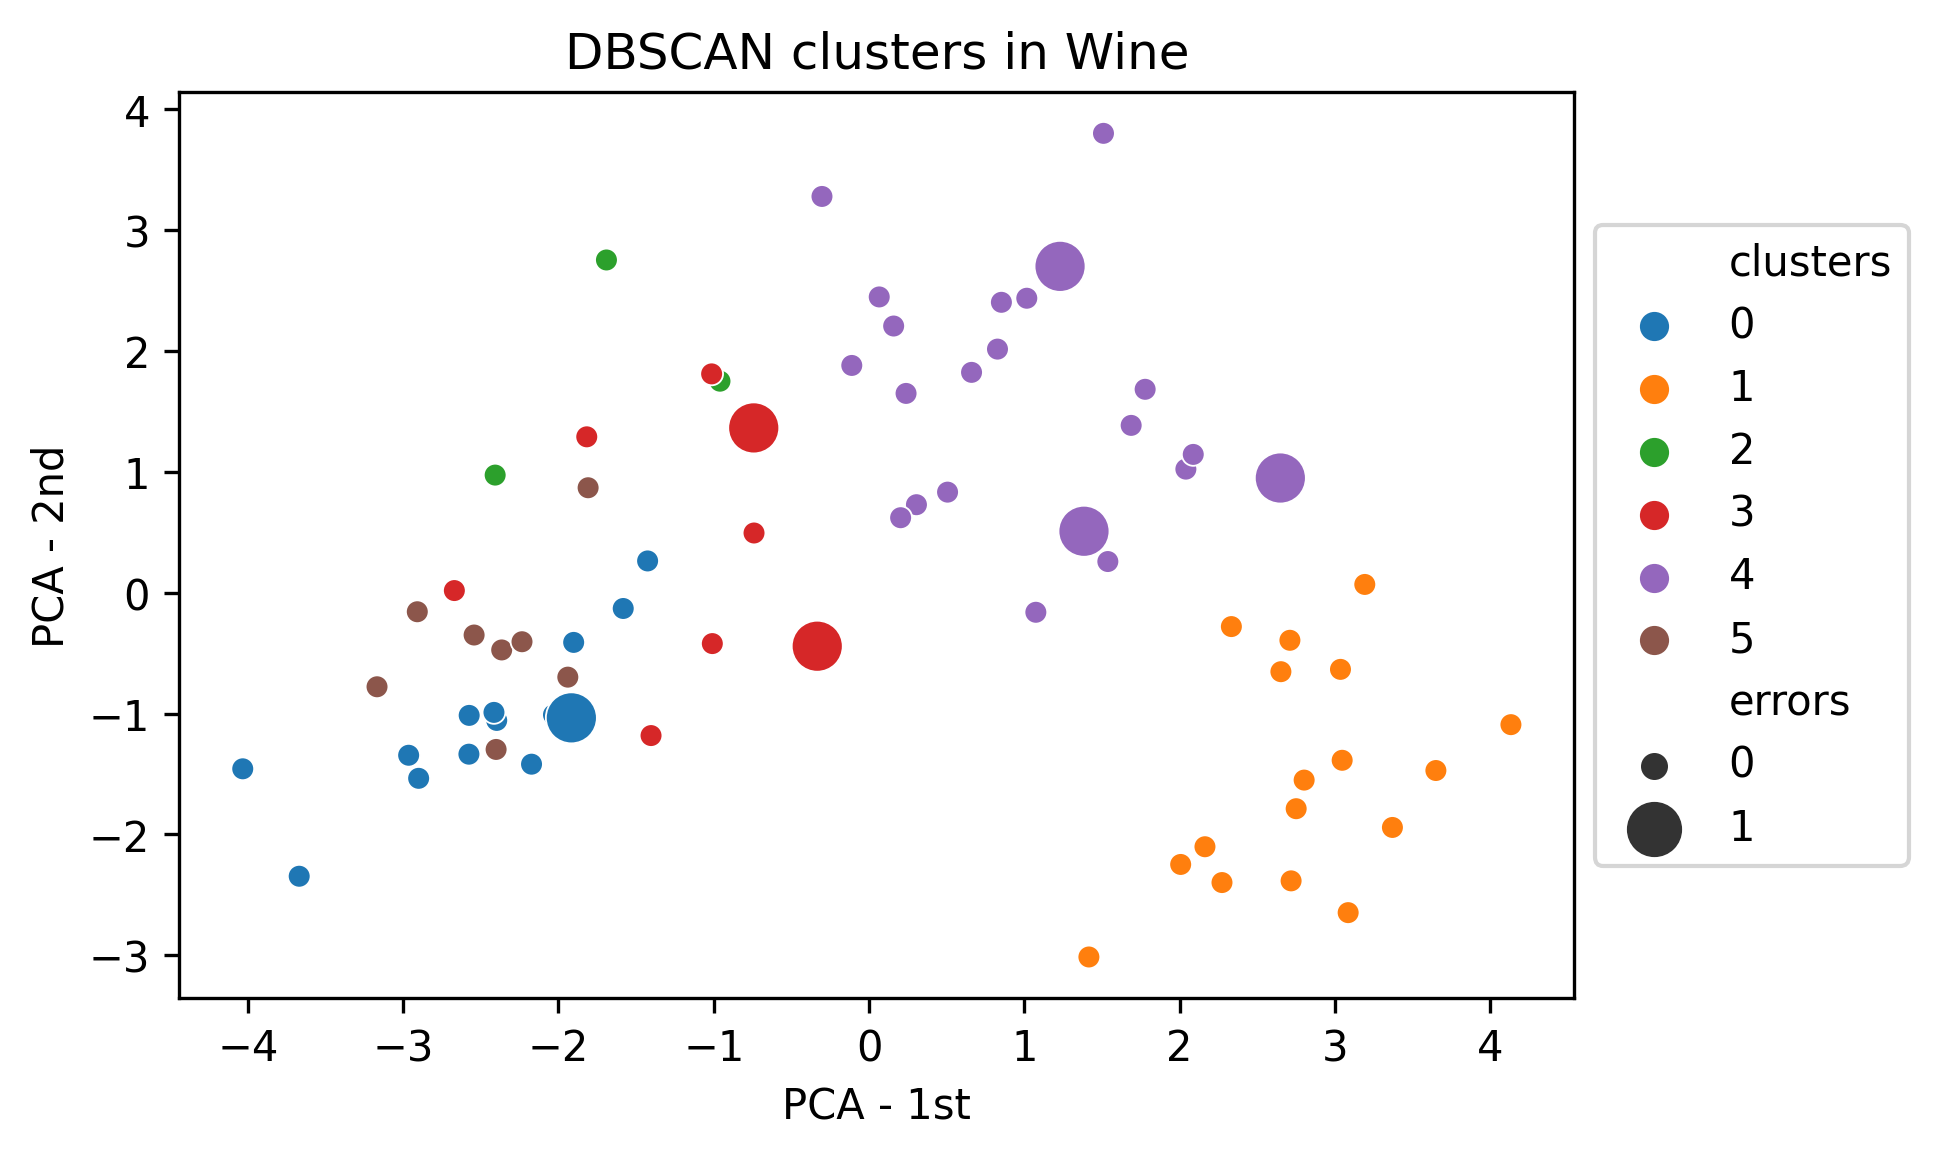

--> Cluster with the highest variance: 4
--> Cluster with the highest variance: 3


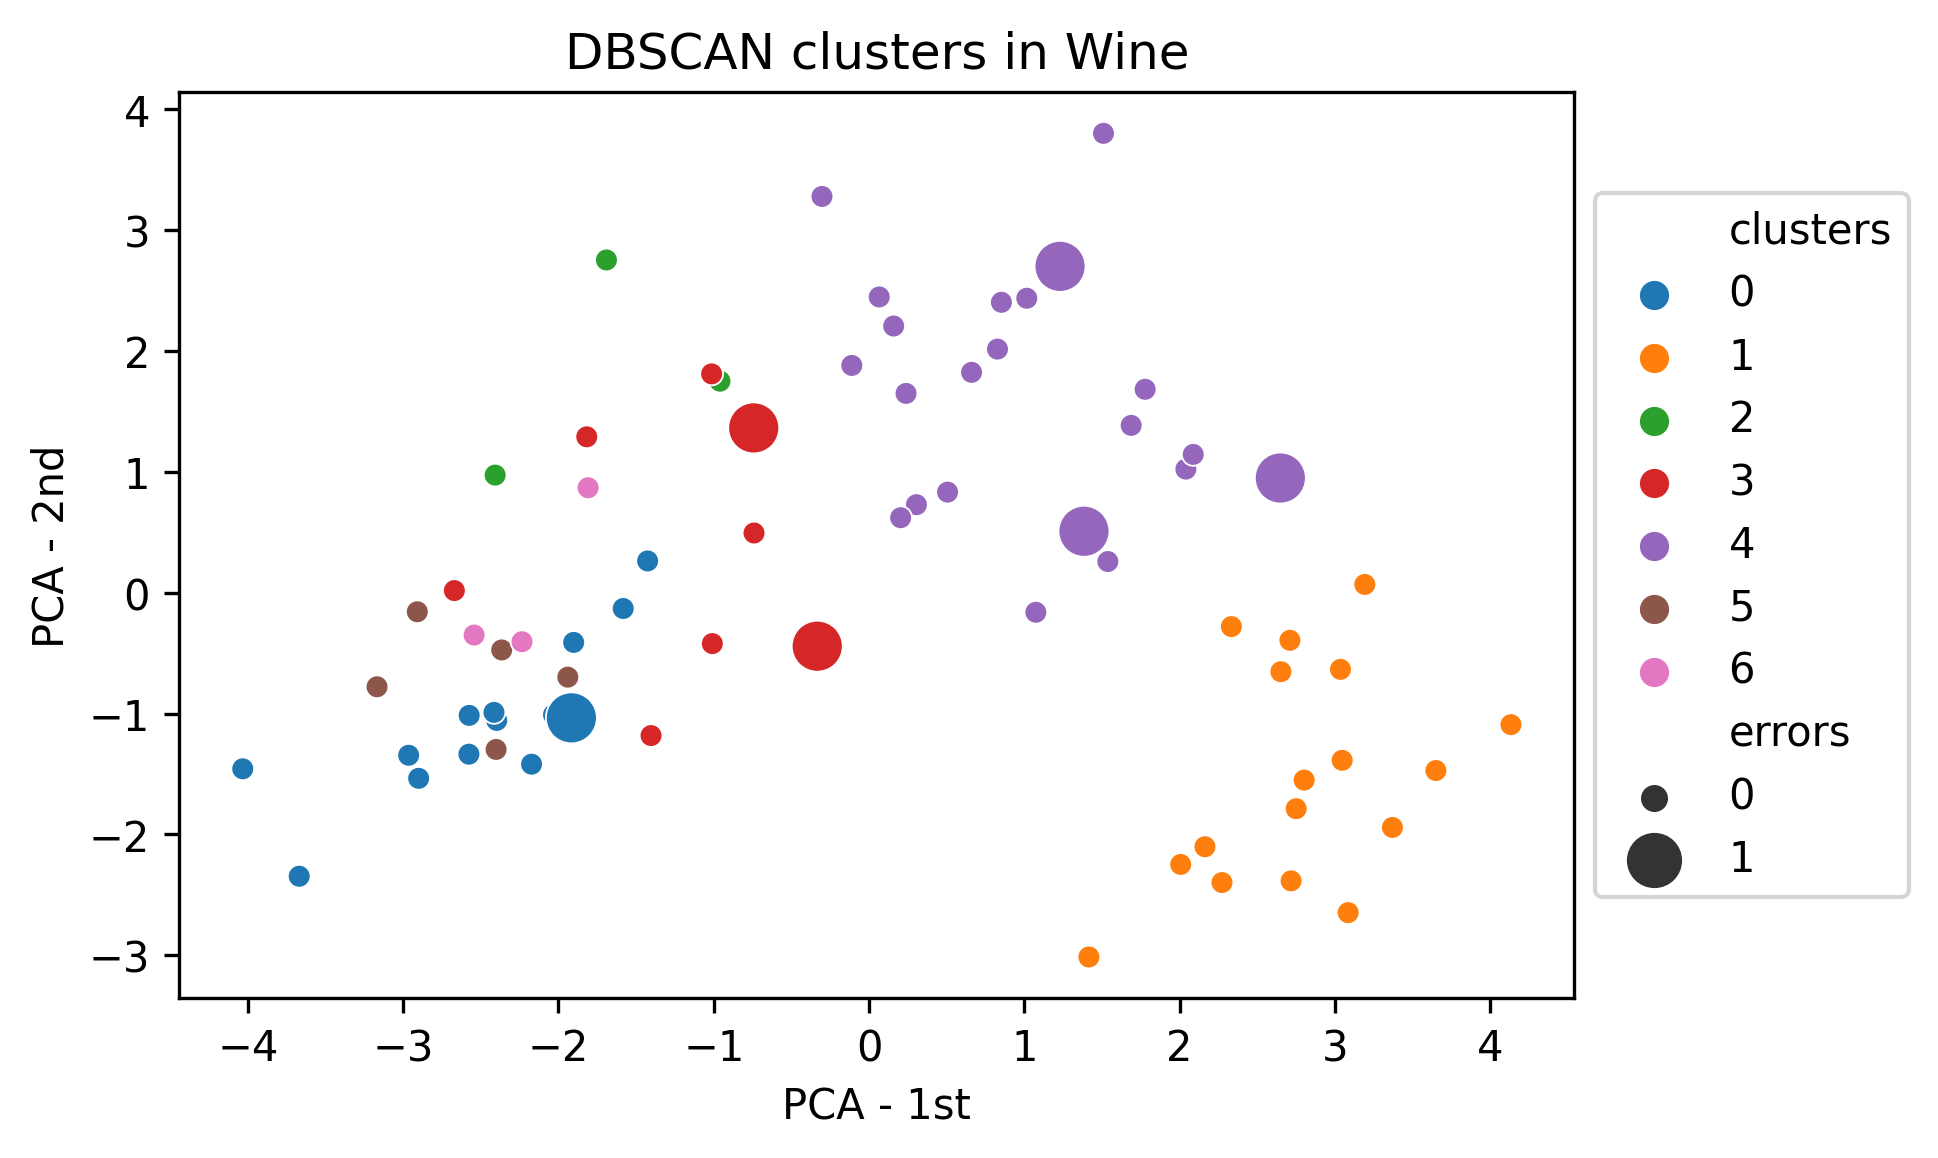

--> Cluster with the highest variance: 4
--> Cluster with the highest variance: 3


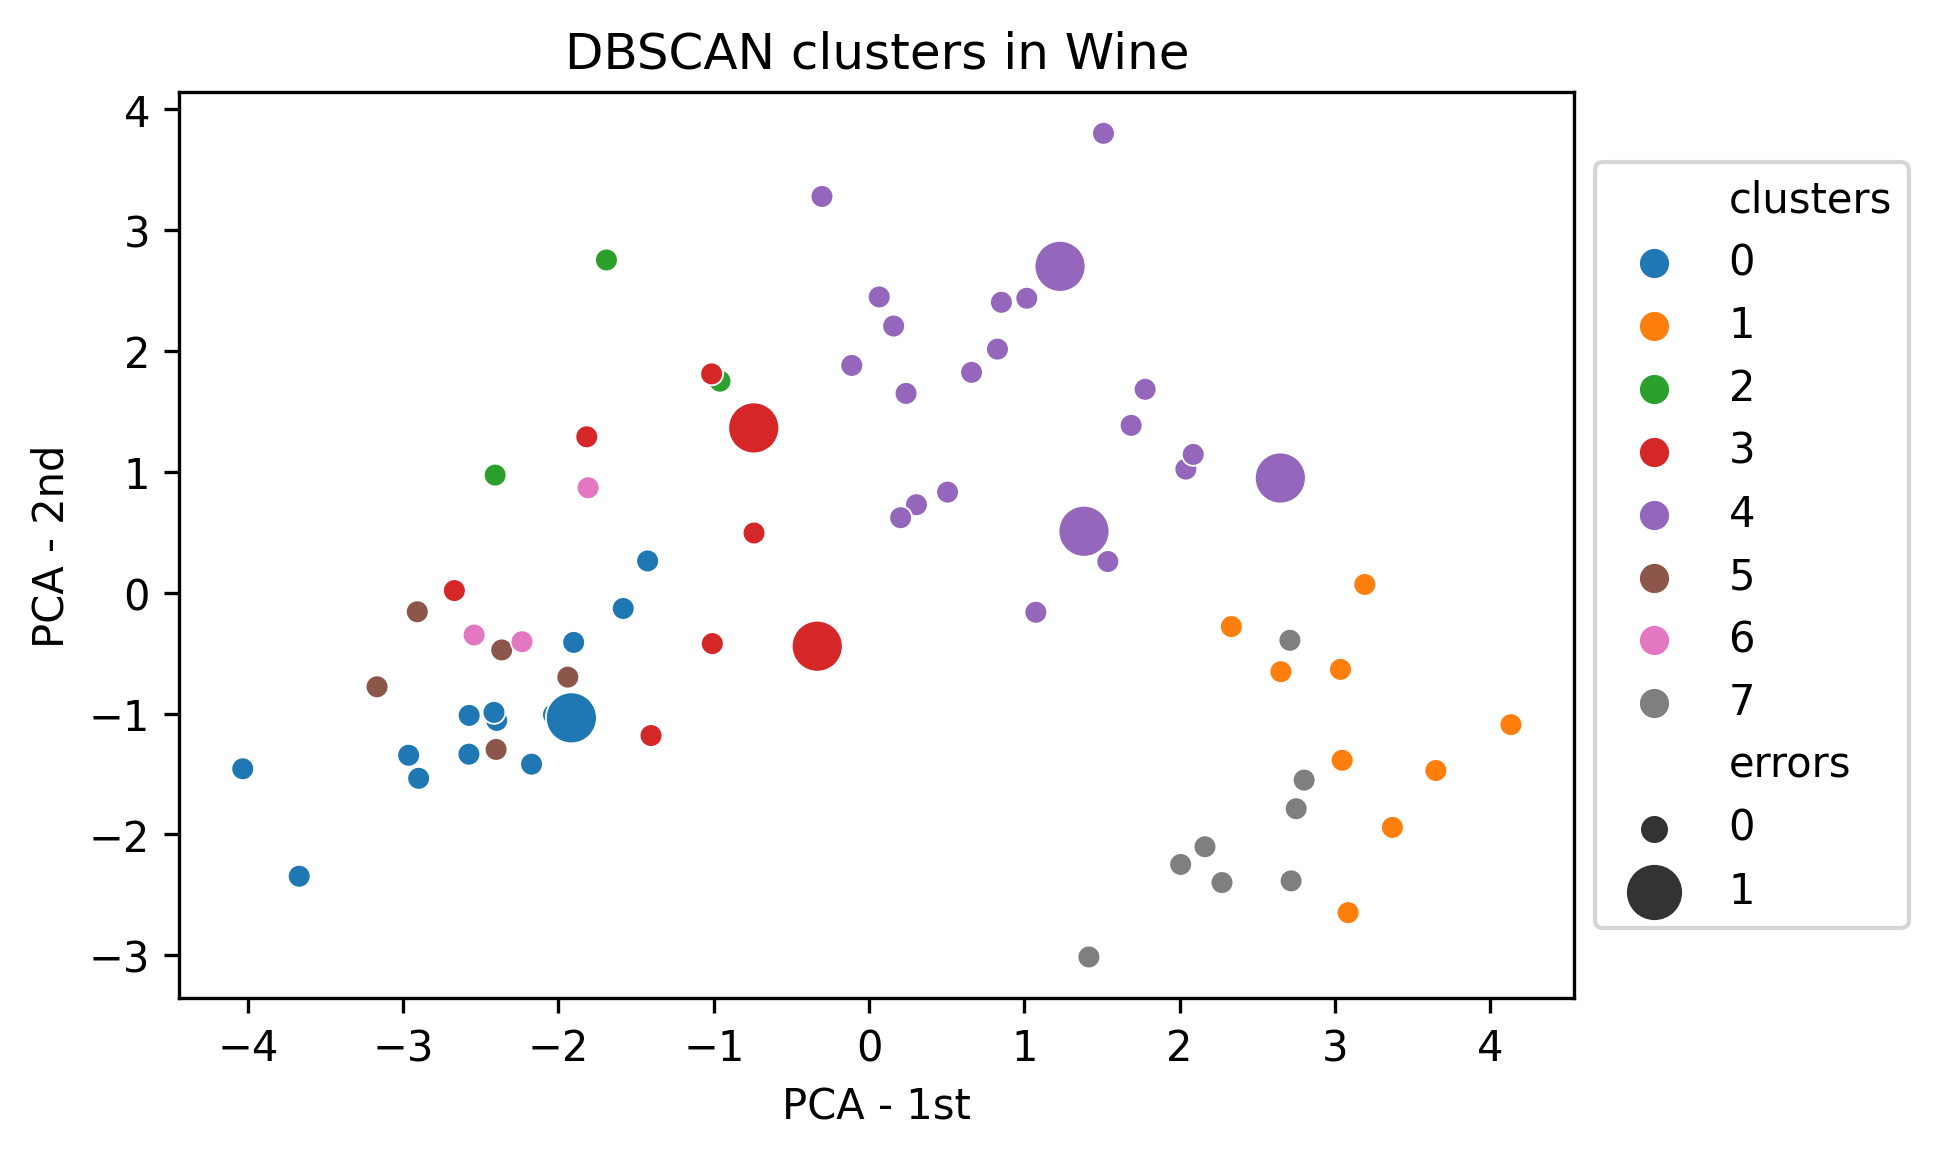

--> Cluster with the highest variance: 4
--> Cluster with the highest variance: 3


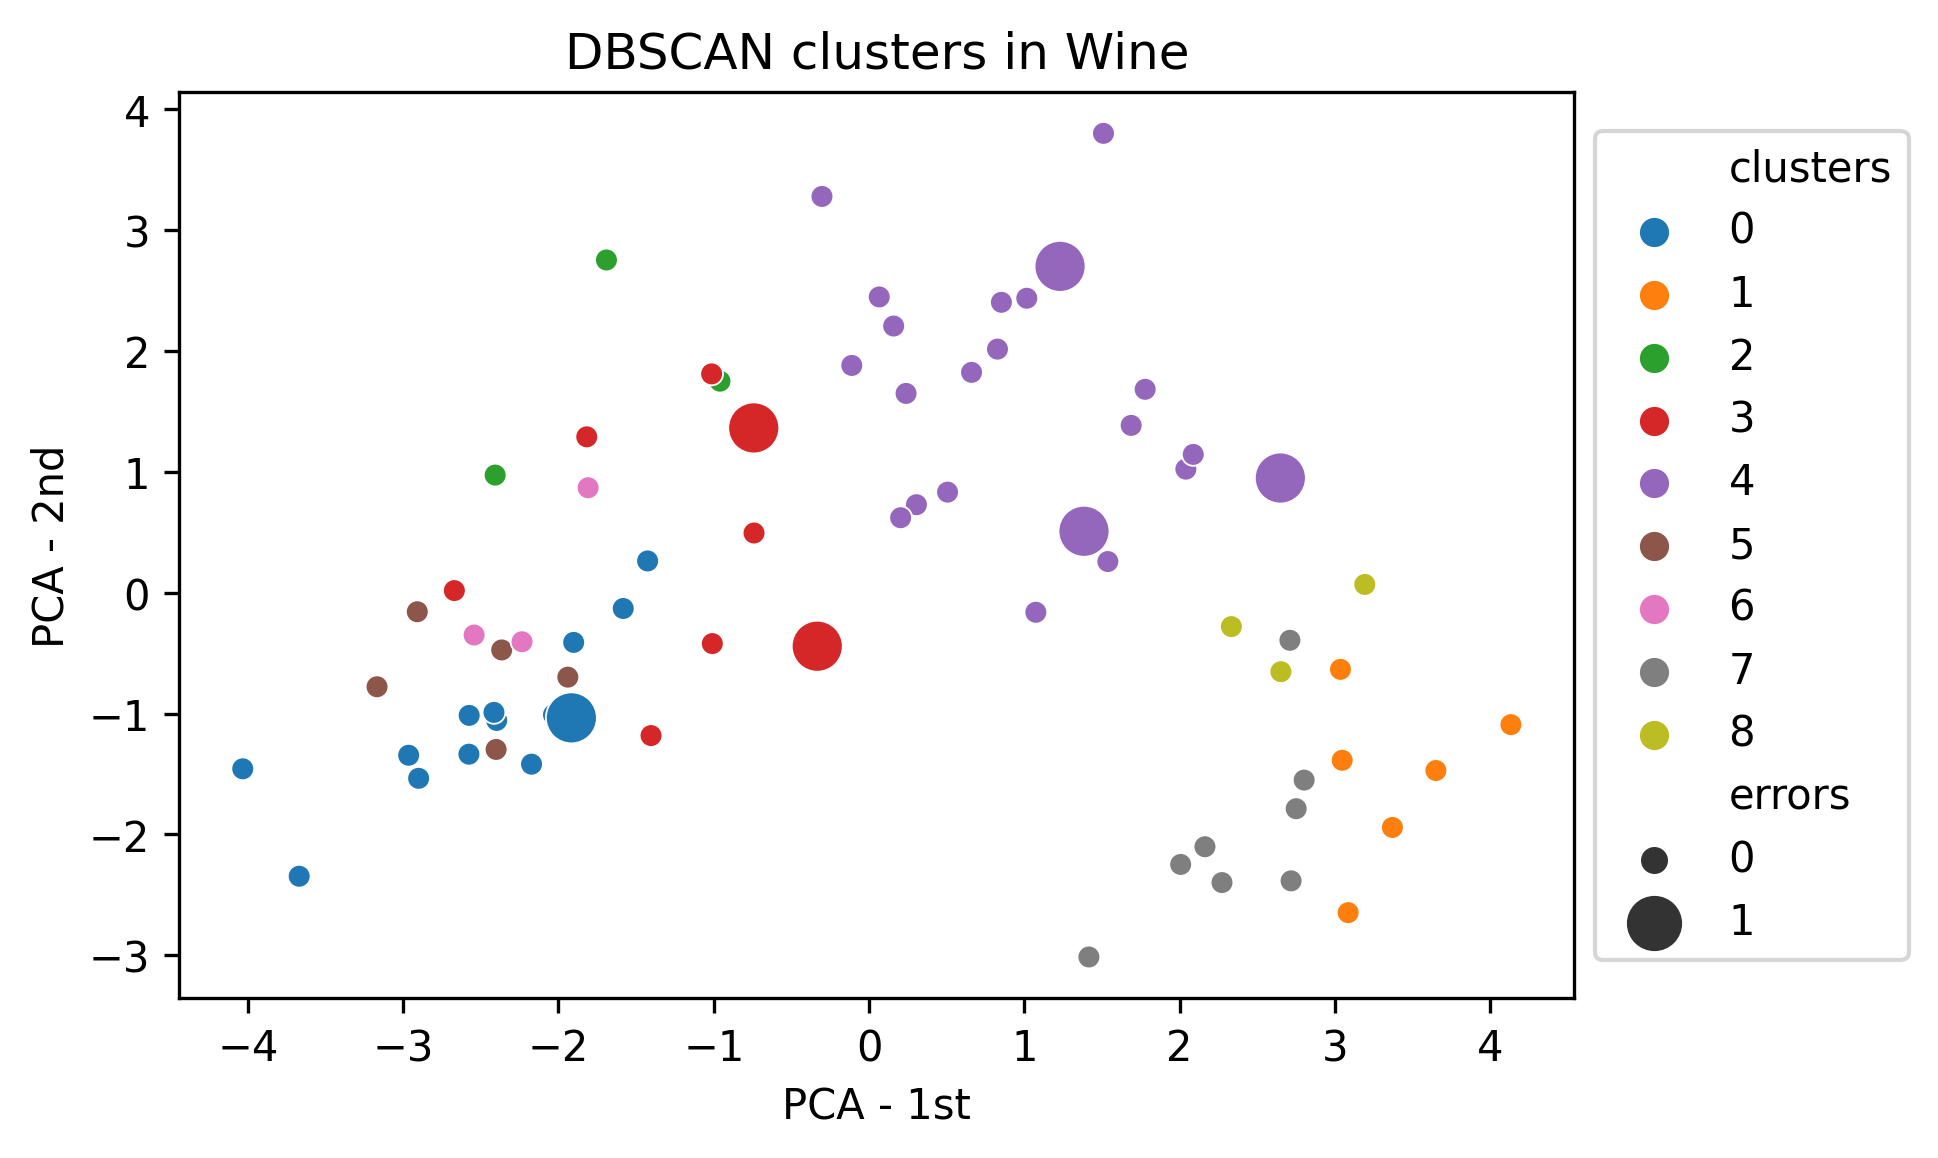

--> Cluster with the highest variance: 4
--> Cluster with the highest variance: 3
MAX_ITER
[0.0001956085872169811, 0.005308245575562243, 0.011408077420006572, 0.011408077420006572, 0.012677980424627788, 0.012677980424627788, 0.011530188892965518, 0.011530188892965518, 0.010581641665209878, 0.010581641665209878, 0.010581641665209878, 0.010581641665209878, 0.009629758332487382, 0.009629758332487382, 0.008875036543378297, 0.008875036543378297, 0.008875036543378297, 0.008875036543378297]


In [55]:
MAX_ITER = 20
x = 0 # initial cluster number
initial_bias = 0
pca_plot(full_data)
variance_list = []
average_accuracy = accuracy(full_data)
minimal_splittable_cluster_size = round(0.05 * len(full_data))
minimal_acceptable_cluster_size = round(0.03 * len(full_data))
print("average_accuracy is: ", average_accuracy) 

for i in range(1, MAX_ITER):
    if i != 1:
        variance_list.append(calculate_variance(full_data)) 
    full_data['new_clusters'] = -1
    candidate_cluster = full_data.loc[full_data['clusters'] == x] 

    if len(candidate_cluster) < minimal_splittable_cluster_size:
        x = get_random_cluster(full_data['clusters'])
        continue
    
    # Apply Kmeans 
    kmeans_algo = KMeans(**clus_model_kwargs).fit(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1))
    
    candidate_cluster['new_clusters'] = pd.DataFrame(kmeans_algo.predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1)),index=candidate_cluster.index) 
    full_data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(full_data['new_clusters'])

    max_abs_bias = get_max_negative_bias(full_data) # was get_max_abs_bias, but now it only finds the discriminated clusters
    min_new_size = get_min_cluster_size(full_data)
    
    if (max_abs_bias <= initial_bias) & (min_new_size > minimal_acceptable_cluster_size): #abs: >
        # Add new cluster
        n_cluster = max(full_data['clusters'])
        full_data['clusters'][full_data['new_clusters'] == 1] =  n_cluster + 1
        
        pca_plot(full_data)
        x = get_next_cluster(full_data)
        initial_bias = max_abs_bias
    else:
        x = get_random_cluster(full_data['clusters'])
        
print('MAX_ITER')

print(variance_list)

### 1. Analysing the clustering results


In [ ]:
# Goal 1: Identifying highest biased cluster
c = get_max_bias_cluster(full_data)
highest_biased_cluster = full_data[full_data['clusters']==c]
len(highest_biased_cluster)

accuracy_full_data = accuracy(full_data)
most_biased_cluster_kmeans_aware = bias_acc(full_data, c, 'clusters')
full_data[full_data['clusters']==c]

print('General accuracy of classifier on this dataset:', accuracy_full_data)
# print('Number of clusters: ', full_data['clusters'].unique()) 
print(f"cluster {c} has the highest discrimination bias")
print(most_biased_cluster_kmeans_aware)

In [ ]:
discriminated_cluster = full_data[full_data['clusters']==c]
print('Number of instances in discriminated cluster:', len(discriminated_cluster))
print('Number of errors in discriminated clusters: ', len(discriminated_cluster.loc[discriminated_cluster['errors']==1]))
discriminated_cluster

In [ ]:
not_discriminated = full_data[full_data['clusters']!=c]
difference = (discriminated_cluster.mean()) - (not_discriminated.mean()) 


In [ ]:
# unscaling the discriminated cluster
unscaled_discriminated = raw_data.loc[discriminated_cluster.index, :]

# unscaled other data
unscaled_remaining = raw_data.drop(discriminated_cluster.index)


# print('discriminated:', unscaled_discriminated)
# raw_data.loc[!discriminated_cluster.index, :]

# full_data.iloc[: , : 24]
# print(discriminated_cluster.index)


In [ ]:
unscaled_discriminated = unscaled_discriminated.iloc[: , : 13]
# print(unscaled_discriminated.head())
unscaled_remaining = remaining.iloc[: , : 13]

welch = scipy.stats.ttest_ind(unscaled_discriminated, unscaled_remaining, equal_var=False)
welch.pvalue

In [ ]:
# ridge plot
column_names = unscaled_discriminated.iloc[: , : 13].columns
# full_data.iloc[: , : 24]
column_names

# RidgePlot HBAC - KMeans


In [ ]:
# not_discriminated = full_data[full_data['clusters']!=c]
# df = not_discriminated

# Let's grab only the subset of columns displayed in the example

# column_names = discriminated_cluster.iloc[: , : 14].columns
df = unscaled_discriminated[column_names]

# Not only does 'ridgeplot(...)' come configured with sensible defaults
# but is also fully configurable to your own style and preference!
fig = ridgeplot(
    samples=df.values.T,
    bandwidth=4,
    kde_points=np.linspace(-12.5, 112.5, 400),
    colorscale="viridis",
    colormode="index",
    coloralpha=0.6,
    labels=column_names,
    spacing=5 / 9,
)

# Again, update the figure layout to your liking here
fig.update_layout(
    title="HBAC-KMeans on Wine: Discriminated Cluster distribution",
    height=650,
    width=800,
    plot_bgcolor="rgba(255, 255, 255, 0.0)",
    xaxis_gridcolor="rgba(0, 0, 0, 0.1)",
    yaxis_gridcolor="rgba(0, 0, 0, 0.1)",
    yaxis_title="Assigned Probability (%)",
)
fig.show()

In [ ]:
variance_df_kmeans = pd.DataFrame(variance_list).rename(columns={0:"variance incl errors"})
sns.lineplot(data=variance_df_kmeans, x=variance_df_kmeans.index,y="variance incl errors").set_title('Variance of Instances')

## Baseline KMeans

In [ ]:
full_data = initialize_dataset(raw_data)
full_data.head()

In [ ]:
# Same number of clusters as the found clusters by the bias-aware clustering algorithm?
baseline_kmeans = KMeans(n_clusters=11, init="k-means++", n_init=10, max_iter=300, random_state=2).fit(full_data.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1))

full_data['clusters'] = pd.DataFrame(baseline_kmeans.predict(full_data.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class',
                    'errors'], axis=1)),index=full_data.index) 


In [ ]:
# Goal 1: Identifying highest biased cluster
c = get_max_bias_cluster(full_data)
print(f"cluster {c} has the highest negative bias")
print(full_data['clusters'].unique())
highest_biased_cluster = full_data[full_data['clusters']==c]
len(highest_biased_cluster)

accuracy_full_data = accuracy(full_data)
print('Overall accuracy:', accuracy_full_data)

most_biased_cluster_baselinekm = bias_acc(full_data, c, 'clusters')

full_data[full_data['clusters']==c]
print('Highest found discrimination bias:', most_biased_cluster_baselinekm)

In [ ]:
discriminated_cluster = full_data[full_data['clusters']==c]
print('Number of instances in discriminated cluster:', len(discriminated_cluster))
print('Number of errors in discriminated clusters: ', len(discriminated_cluster.loc[discriminated_cluster['errors']==1]))
discriminated_cluster

In [ ]:
# Full dataset ridgeplot

df = raw_data
column_names = raw_data.iloc[: , : 13].columns

df = df[column_names]
df.head()

In [ ]:
# not_discriminated = full_data[full_data['clusters']!=c]
# df = not_discriminated

# Let's grab only the subset of columns displayed in the example
# column_names = ["x", "y", "scaled_errors", "errors"]
# column_names = discriminated_cluster.iloc[: , : 14].columns
# df = df[column_names]

# Not only does 'ridgeplot(...)' come configured with sensible defaults
# but is also fully configurable to your own style and preference!
fig = ridgeplot(
    samples=df.values.T,
    bandwidth=4,
    kde_points=np.linspace(-12.5, 112.5, 400),
    colorscale="viridis",
    colormode="index",
    coloralpha=0.6,
    labels=column_names,
    spacing=5 / 9,
)

# Again, update the figure layout to your liking here
fig.update_layout(
    title="What is the distribution of the highly discriminated cluster?",
    height=650,
    width=800,
    plot_bgcolor="rgba(255, 255, 255, 0.0)",
    xaxis_gridcolor="rgba(0, 0, 0, 0.1)",
    yaxis_gridcolor="rgba(0, 0, 0, 0.1)",
    yaxis_title="Assigned Probability (%)",
)
fig.show()

## 2. Bias-Aware DBSCAN

In [8]:
from sklearn.cluster import DBSCAN

In [56]:
full_data = initialize_dataset(raw_data)
full_data.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,scaled_errors,predicted_class,true_class,errors,clusters,new_clusters
104,-0.669074,-0.481192,-1.166817,0.461386,-0.963795,-0.130285,-0.137723,-0.284577,-0.211402,-1.025689,0.361193,1.354564,-0.225753,0.0,1,1,0,0,-1
67,-0.847070,-0.970763,-1.370315,0.208443,-1.360004,-0.265798,-0.063096,-0.686333,-0.903977,-0.239382,0.710266,1.229242,-0.714467,0.0,1,1,0,0,-1
118,-0.338510,1.005004,-1.166817,-0.803327,-1.246801,-0.988536,-0.762724,0.599286,-1.234524,-0.817815,-1.122366,-0.664518,-1.130778,0.8,2,1,1,0,-1
39,1.505019,1.494574,0.630750,-1.590260,1.470062,1.074278,0.907054,-1.248791,0.733019,-0.049584,-0.293318,1.298865,0.039721,0.0,0,0,0,0,-1
176,0.170050,0.270648,0.155921,0.320862,1.017252,-0.958422,-1.294440,1.402798,-0.242882,1.848400,-1.558707,-1.360753,0.281061,0.0,2,2,0,0,-1


## Determining epsilon

Text(0.5, 1.0, 'Determining Optimal Value Epsilon')

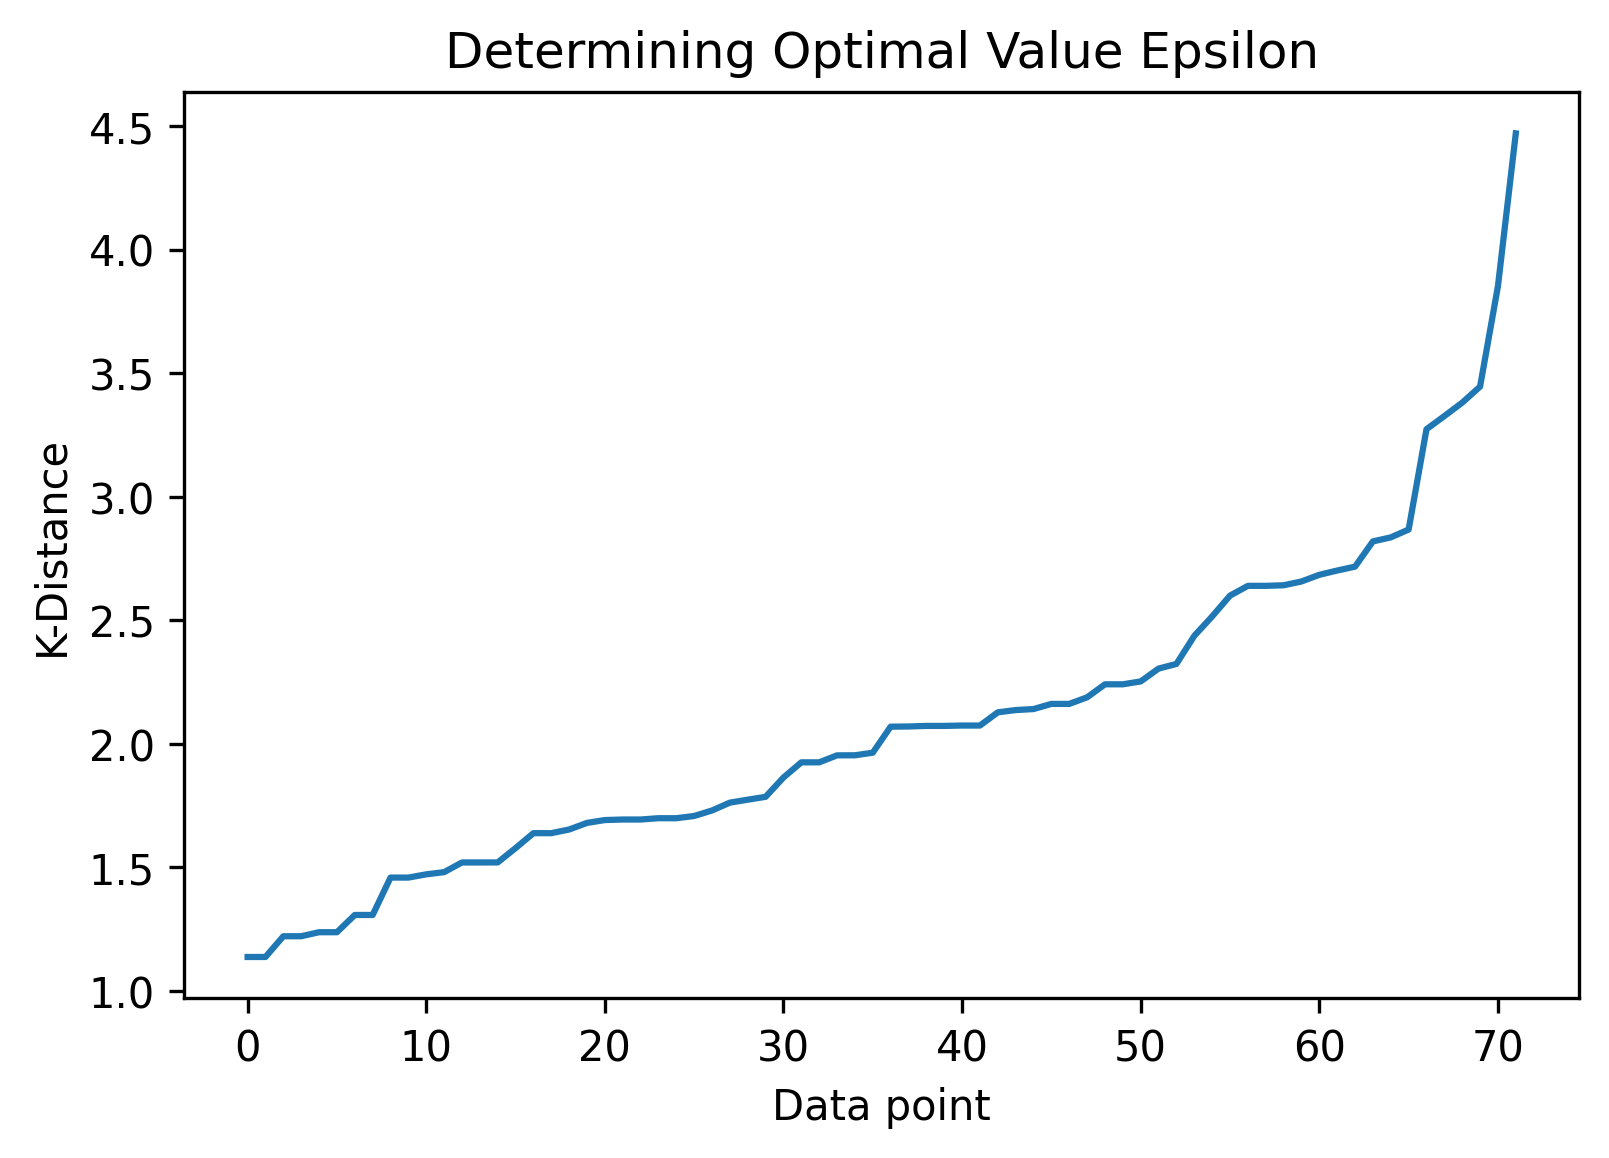

In [57]:
# determining epsilon
from sklearn.neighbors import NearestNeighbors

#for wine dataset
nn_features = full_data.iloc[: , : 14] #wine + including scaled errors
# for german credit:
# nn_features = full_data.iloc[: , : 25]

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(nn_features)
distances, indices = nbrs.kneighbors(nn_features)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.xlabel('Data point')
plt.ylabel('K-Distance')
plt.title('Determining Optimal Value Epsilon')

# plt.savefig('dbscan_wine_epsilon.png', dpi=300)

In [17]:
round(0.05 * len(full_data))

4

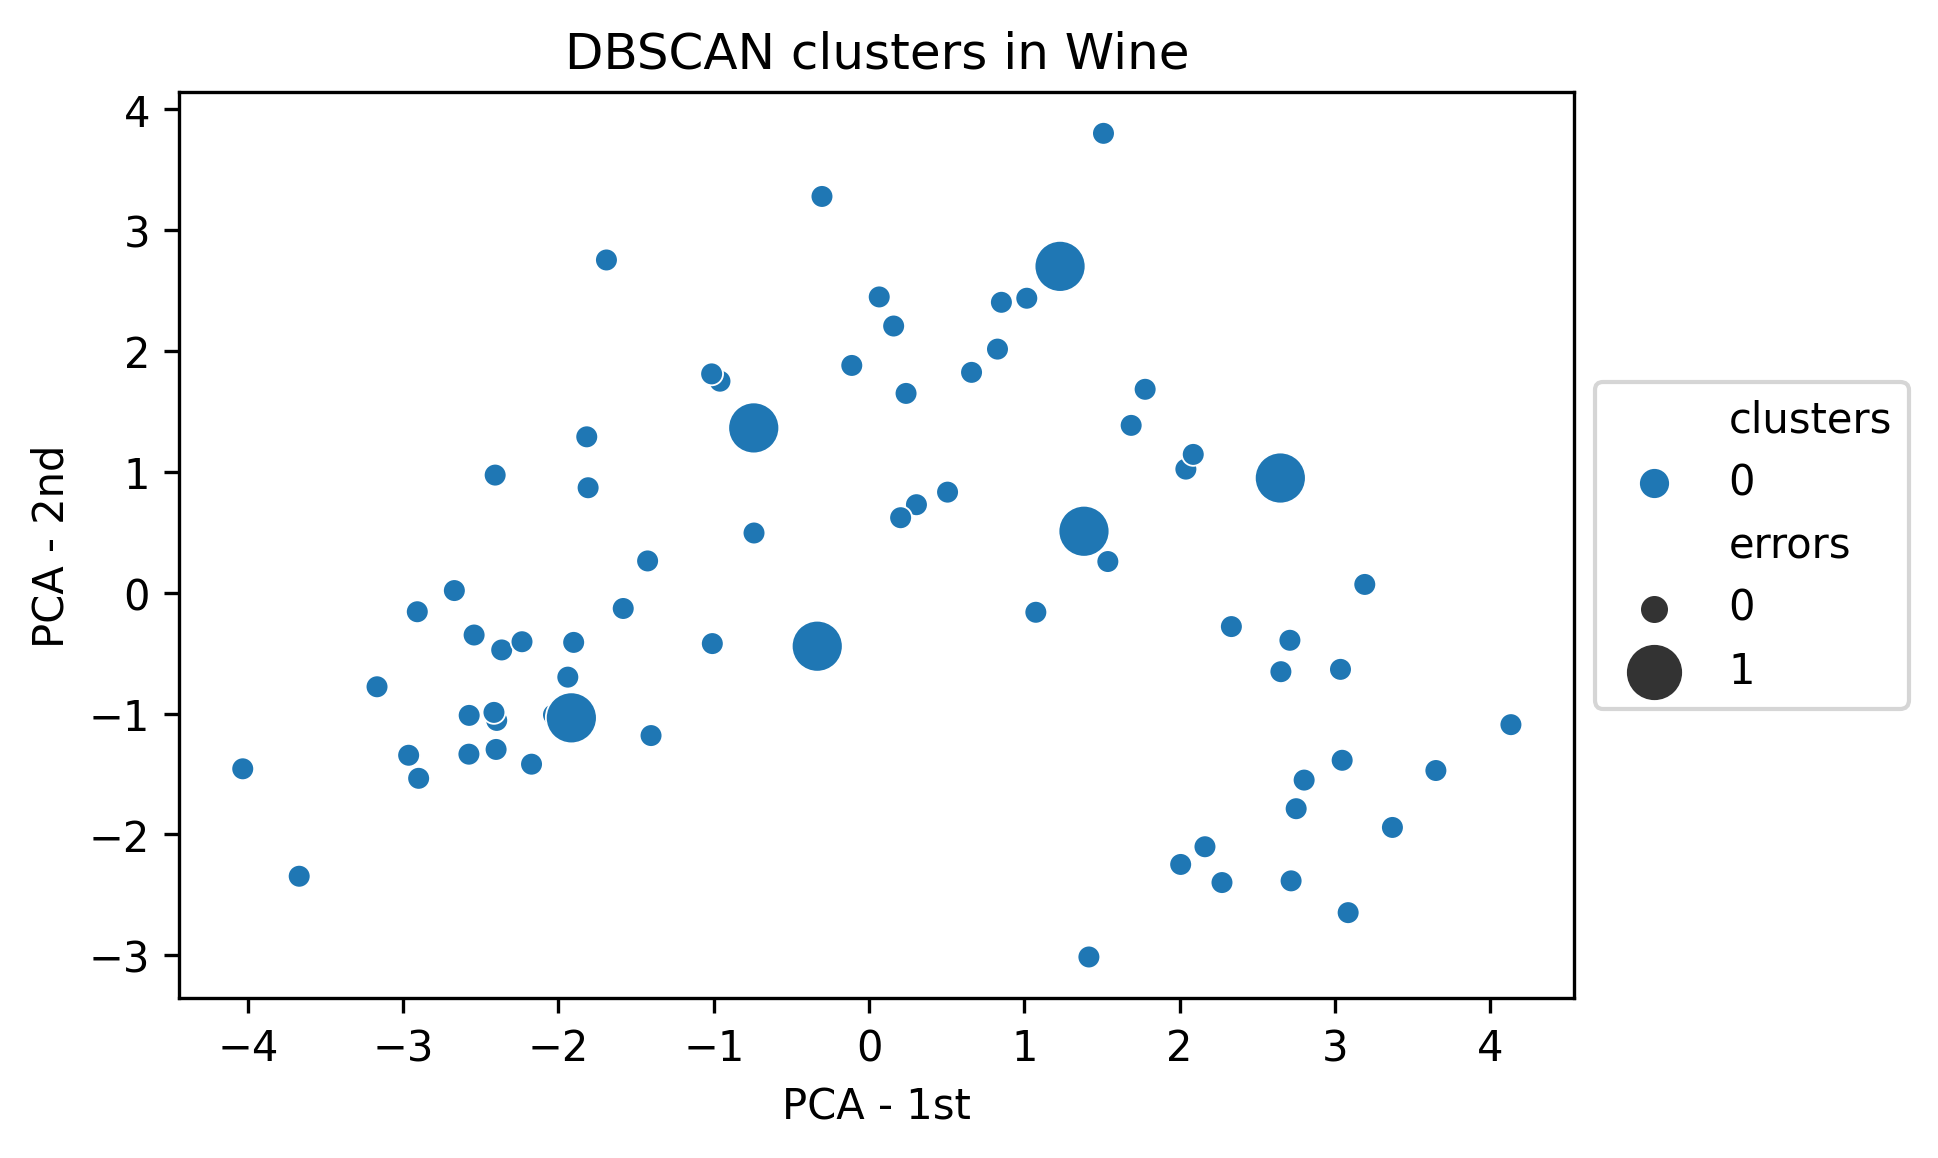

this is the current cluster:  0
smallest cluster:  5


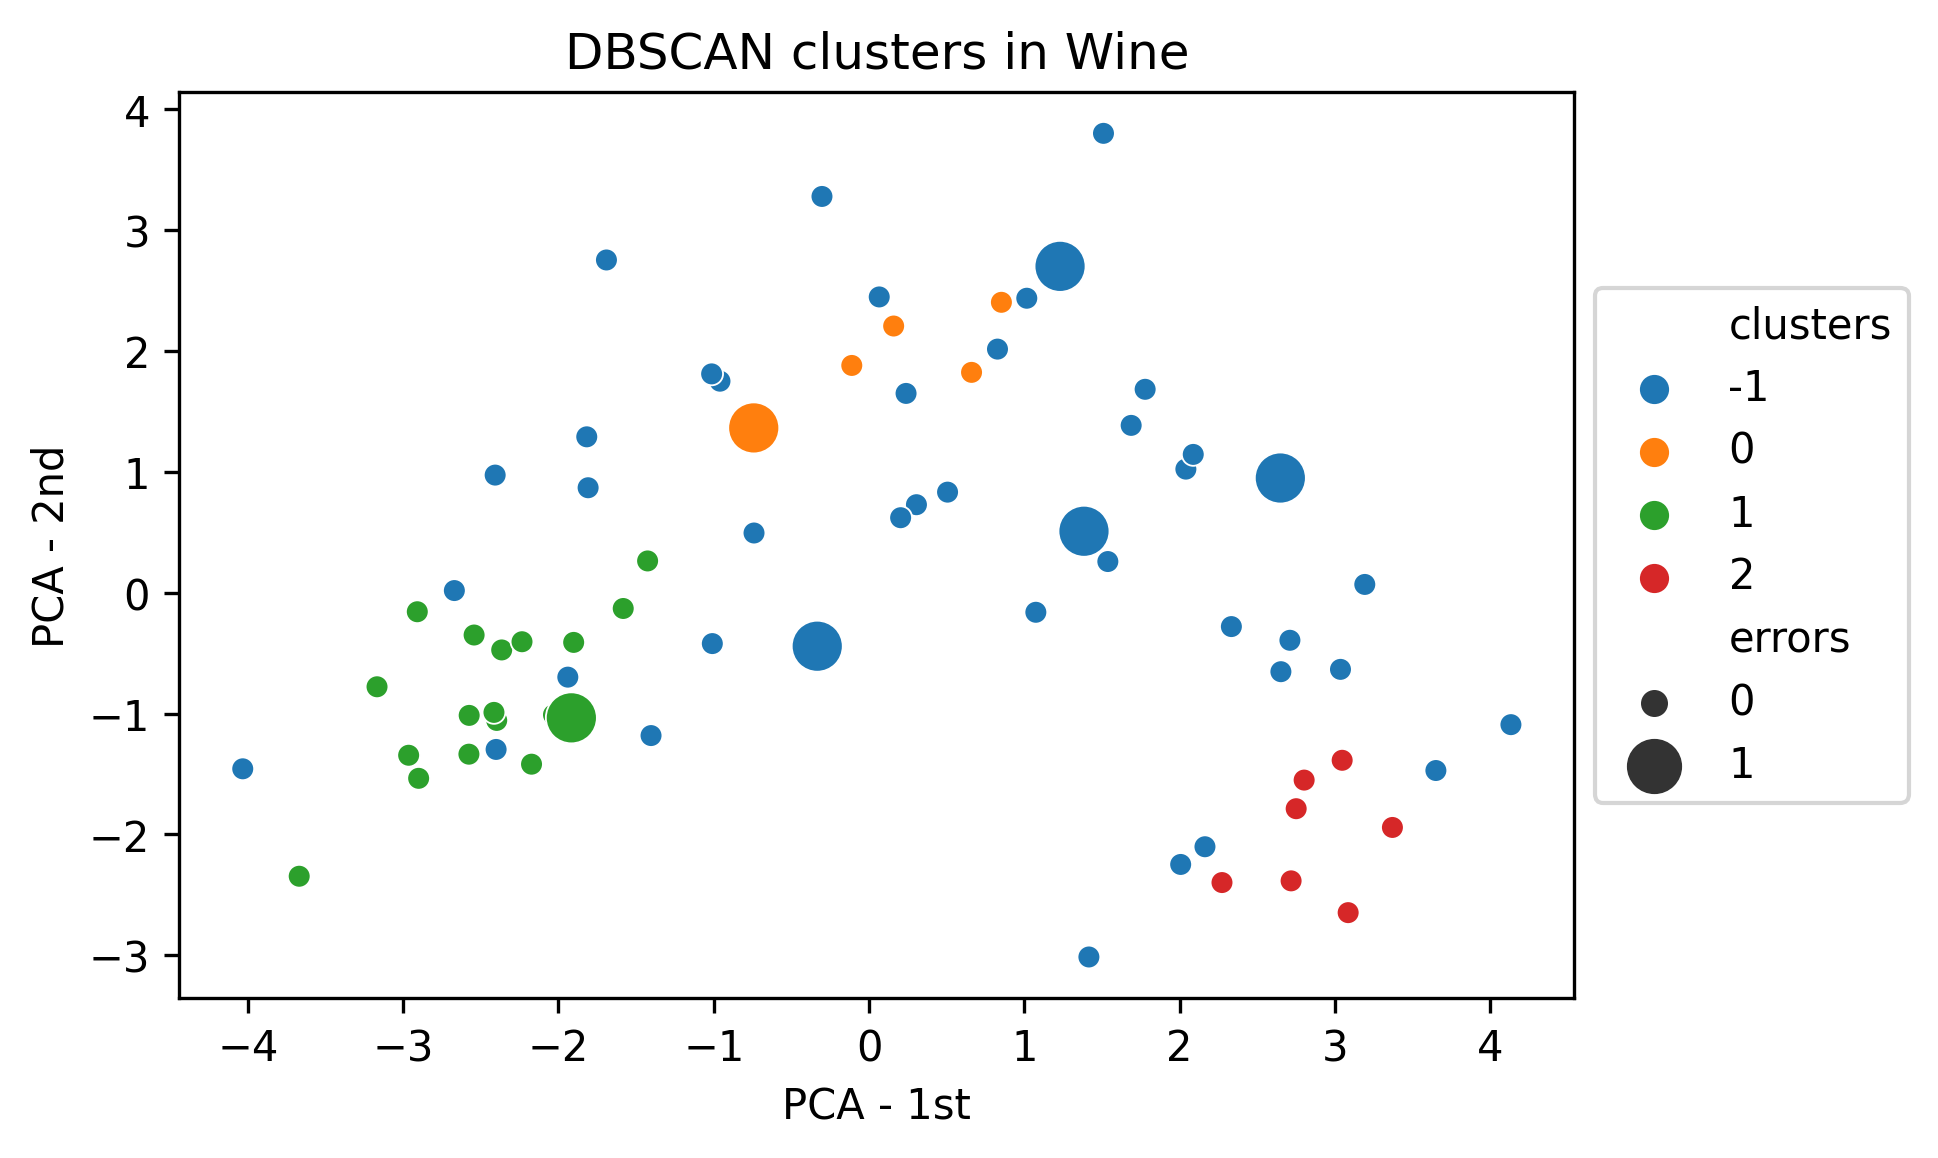

--> Cluster with the highest variance: 0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
MAX_ITER
0.9166666666666666
[0.006568978390212275, 0.006568978390212275, 0.006568978390212275, 0.006568978390212275, 0.006568978390212275, 0.006568978390212275, 0.006568978390212275, 0.006568978390212275, 0.006568978390212275, 0.006568978390212275, 0.006568978390212275, 0.006568978390212275, 0.006568978390212275, 0.006568978390212275, 0.006568978390212275, 0.006568978390212275, 0.

In [58]:
MAX_ITER = 20
epsilon =  2
minimum_samples = 3 # round(0.02 * len(full_data)) # 2*dim?
x = 0 # cluster number
initial_bias = 0
pca_plot(full_data)
variance_list = []
minimal_splittable_cluster_size = round(0.03 * len(full_data))
minimal_acceptable_cluster_size = round(0.01 * len(full_data))
average_accuracy = accuracy(full_data)

for i in range(1, MAX_ITER):
    print('this is the current cluster: ', x)
    epsilon = epsilon + 0.001
    if len(full_data['clusters'].unique()) != 1:
        variance_list.append(calculate_variance(full_data))

    full_data['new_clusters'] = -2
    candidate_cluster = full_data.loc[full_data['clusters'] == x] 

    if len(candidate_cluster) < minimal_splittable_cluster_size:
        x = get_random_cluster(full_data['clusters'])
        continue
    
    # Apply DBSCAN
    candidate_cluster['new_clusters'] = pd.DataFrame(DBSCAN(eps=epsilon, min_samples=minimum_samples).fit_predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1)), index=candidate_cluster.index)

    full_data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(full_data['new_clusters'])
    
    if (len(full_data['new_clusters'].unique()) <= 2): # to check whether a new cluster is found
        continue

    max_neg_bias = get_max_negative_bias(full_data) #get max abs bias
    min_new_size = get_min_cluster_size(full_data)
    print("smallest cluster: ", min_new_size)
    
    if (max_neg_bias <= initial_bias) & (min_new_size > minimal_acceptable_cluster_size): #>
        # Add new cluster
        n_cluster = max(full_data['clusters'])
        # print(full_data['new_clusters'])
        
        first = True
        dif = 1
        for clstr in full_data['new_clusters'].unique():
            if (clstr == -1):
                full_data['clusters'][full_data['new_clusters'] == clstr] = -1
            elif (clstr == -2):
                continue
            elif first:
                full_data['clusters'][full_data['new_clusters'] == clstr] = x
                first = False
            else:
                full_data['clusters'][full_data['new_clusters'] == clstr] =  n_cluster + dif
                dif += 1

        pca_plot(full_data)
        x = get_next_cluster(full_data)
        initial_bias = max_neg_bias
    else:
        x = get_random_cluster(full_data['clusters'])
        
print('MAX_ITER')
print(average_accuracy)
print(variance_list)

## 2. DBSCAN Results

In [60]:
# Goal 1: Identifying highest biased cluster
c = get_max_bias_cluster(full_data) #shouldn't this be max_neg_bias_cluster
print(f"cluster {c} has the highest negative bias")
print(full_data['clusters'].unique())
highest_biased_cluster = full_data[full_data['clusters']==c]
len(highest_biased_cluster)

accuracy_full_data = accuracy(full_data)
print('Overall accuracy:', accuracy_full_data)

most_biased_cluster_dbscan_aware = bias_acc(full_data, c, 'clusters')

full_data[full_data['clusters']==c]
print('Highest found negative bias:', most_biased_cluster_dbscan_aware)

0 has bias -0.12537313432835817
1 has bias 0.03703703703703698
2 has bias 0.09230769230769231
cluster 0 has the highest negative bias
[ 0 -1  1  2]
Overall accuracy: 0.9166666666666666
Highest found negative bias: -0.12537313432835817


In [61]:
discriminated_cluster = full_data[full_data['clusters']==c]
print('Number of instances in discriminated cluster:', len(discriminated_cluster))
print('Number of errors in discriminated clusters: ', len(discriminated_cluster.loc[discriminated_cluster['errors']==1]))
discriminated_cluster



Number of instances in discriminated cluster: 5
Number of errors in discriminated clusters:  1


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,scaled_errors,predicted_class,true_class,errors,clusters,new_clusters
104,-0.669074,-0.481192,-1.166817,0.461386,-0.963795,-0.130285,-0.137723,-0.284577,-0.211402,-1.025689,0.361193,1.354564,-0.225753,0.0,1,1,0,0,0.0
67,-0.847070,-0.970763,-1.370315,0.208443,-1.360004,-0.265798,-0.063096,-0.686333,-0.903977,-0.239382,0.710266,1.229242,-0.714467,0.0,1,1,0,0,0.0
101,-0.554648,-0.822143,-1.438148,-0.100709,-0.793991,-1.259563,-0.660111,-0.525631,-0.416026,-1.247121,0.361193,0.240588,-0.557596,0.0,1,1,0,0,0.0
81,-0.402080,-0.411254,-0.420657,-0.016394,-0.907193,-0.130285,0.431307,-0.766684,0.245068,-0.591864,0.884802,0.755802,-0.099050,0.8,0,1,1,0,0.0
106,-0.999638,-0.481192,-0.691988,0.039815,-1.246801,-0.958422,-0.035111,0.117179,0.024704,-0.817815,0.186657,0.797576,-0.714467,0.0,1,1,0,0,0.0


In [ ]:
full_data = initialize_dataset(raw_data)

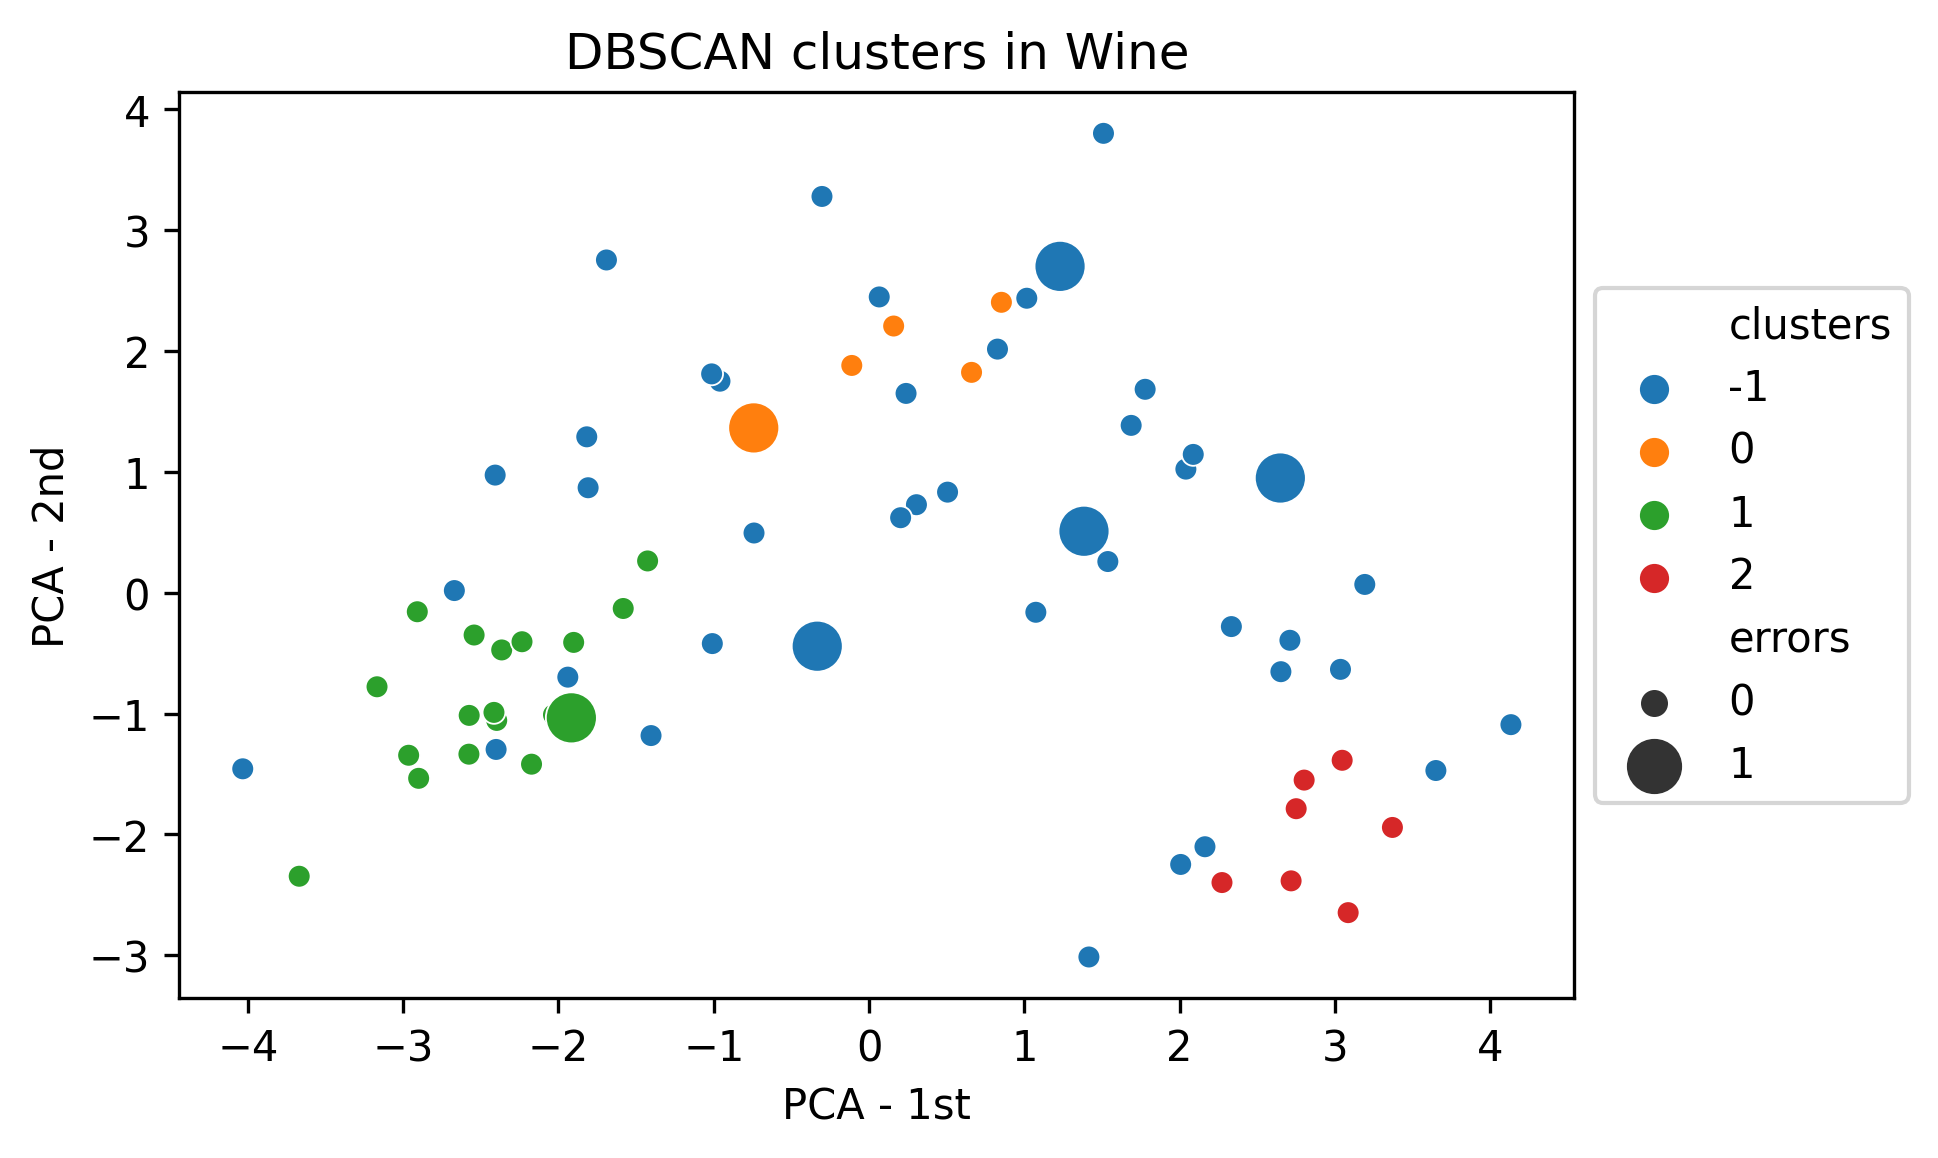

In [62]:
# Baseline DBSCAN

epsilon = 2
min_samples = 3
full_data['clusters'] = pd.DataFrame(DBSCAN(eps=epsilon, min_samples=3).fit_predict(full_data.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1)), index=full_data.index)

pca_plot(full_data)

In [63]:
# Goal 1: Identifying highest biased cluster
c = get_max_bias_cluster(full_data)
print(f"cluster {c} has the highest negative bias")
print(full_data['clusters'].unique())
highest_biased_cluster = full_data[full_data['clusters']==c]
len(highest_biased_cluster)

accuracy_full_data = accuracy(full_data)
print('Overall accuracy:', accuracy_full_data)

most_biased_cluster_dbscan_aware = bias_acc(full_data, c, 'clusters')

full_data[full_data['clusters']==c]
print('Highest found negative bias:', most_biased_cluster_dbscan_aware)

0 has bias -0.12537313432835817
1 has bias 0.03703703703703698
2 has bias 0.09230769230769231
cluster 0 has the highest negative bias
[ 0 -1  1  2]
Overall accuracy: 0.9166666666666666
Highest found negative bias: -0.12537313432835817


In [64]:
discriminated_cluster = full_data[full_data['clusters']==c]
print('Number of instances in discriminated cluster:', len(discriminated_cluster))
print('Number of errors in discriminated clusters: ', len(discriminated_cluster.loc[discriminated_cluster['errors']==1]))
discriminated_cluster



Number of instances in discriminated cluster: 5
Number of errors in discriminated clusters:  1


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,scaled_errors,predicted_class,true_class,errors,clusters,new_clusters
104,-0.669074,-0.481192,-1.166817,0.461386,-0.963795,-0.130285,-0.137723,-0.284577,-0.211402,-1.025689,0.361193,1.354564,-0.225753,0.0,1,1,0,0,0.0
67,-0.847070,-0.970763,-1.370315,0.208443,-1.360004,-0.265798,-0.063096,-0.686333,-0.903977,-0.239382,0.710266,1.229242,-0.714467,0.0,1,1,0,0,0.0
101,-0.554648,-0.822143,-1.438148,-0.100709,-0.793991,-1.259563,-0.660111,-0.525631,-0.416026,-1.247121,0.361193,0.240588,-0.557596,0.0,1,1,0,0,0.0
81,-0.402080,-0.411254,-0.420657,-0.016394,-0.907193,-0.130285,0.431307,-0.766684,0.245068,-0.591864,0.884802,0.755802,-0.099050,0.8,0,1,1,0,0.0
106,-0.999638,-0.481192,-0.691988,0.039815,-1.246801,-0.958422,-0.035111,0.117179,0.024704,-0.817815,0.186657,0.797576,-0.714467,0.0,1,1,0,0,0.0


## 3. Bias-Aware Mean Shift 


The estimate_bandwidth function to estimate the bandwidth parameter of Mean Shift is significantly better than manually selecting a bandwidth value.

In [65]:
from sklearn.cluster import MeanShift, estimate_bandwidth 

In [80]:
full_data = initialize_dataset(raw_data)
bandwidth_features = full_data.iloc[: , : 14]
bandwidth_features.head()
# bandwidth_features = full_data.iloc[: , : 24]

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,scaled_errors
104,-0.669074,-0.481192,-1.166817,0.461386,-0.963795,-0.130285,-0.137723,-0.284577,-0.211402,-1.025689,0.361193,1.354564,-0.225753,0.0
67,-0.847070,-0.970763,-1.370315,0.208443,-1.360004,-0.265798,-0.063096,-0.686333,-0.903977,-0.239382,0.710266,1.229242,-0.714467,0.0
118,-0.338510,1.005004,-1.166817,-0.803327,-1.246801,-0.988536,-0.762724,0.599286,-1.234524,-0.817815,-1.122366,-0.664518,-1.130778,0.8
39,1.505019,1.494574,0.630750,-1.590260,1.470062,1.074278,0.907054,-1.248791,0.733019,-0.049584,-0.293318,1.298865,0.039721,0.0
176,0.170050,0.270648,0.155921,0.320862,1.017252,-0.958422,-1.294440,1.402798,-0.242882,1.848400,-1.558707,-1.360753,0.281061,0.0


estimated bandwidth:  3


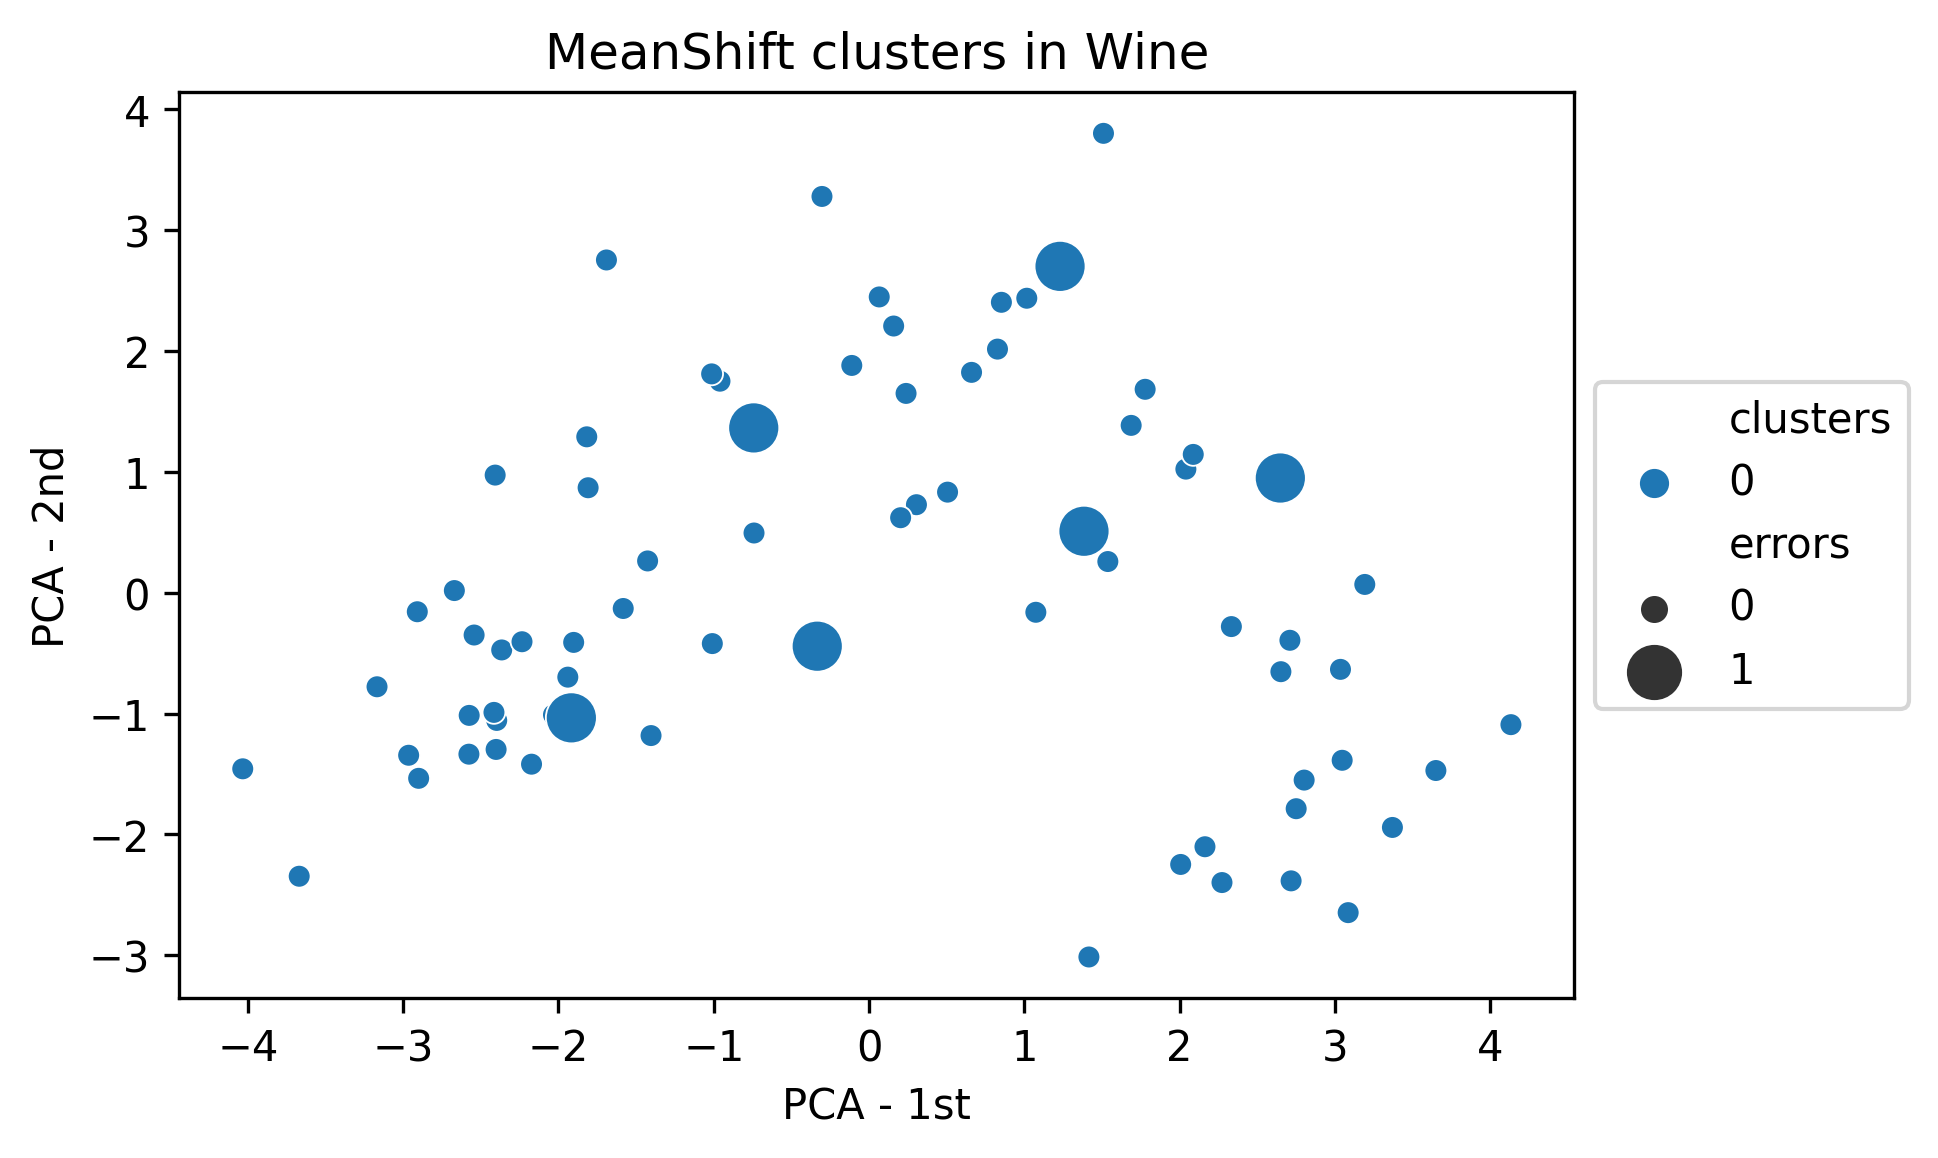

average_accuracy is:  0.9166666666666666
smallest cluster: 1
This cluster is the entire dataset. cluster  0
You are calculating the accuracy on a empty cluster


ZeroDivisionError: division by zero

In [81]:
MAX_ITER = 20
x = 0 # cluster number
initial_bias = 0
bw1 = 3
# bw1 = estimate_bandwidth(bandwidth_features)
print('estimated bandwidth: ', bw1)
pca_plot(full_data)
variance_list = []
average_accuracy = accuracy(full_data) 
minimal_splittable_cluster_size = round(0.05 * len(full_data))
minimal_acceptable_cluster_size = round(0.03 * len(full_data))
print("average_accuracy is: ", average_accuracy) 


for i in range(1, MAX_ITER):
    if i != 1:
        variance_list.append(calculate_variance(full_data)) 
    full_data['new_clusters'] = -1
    candidate_cluster = full_data.loc[full_data['clusters'] == x] 

    if len(candidate_cluster) < minimal_splittable_cluster_size:
        x = get_random_cluster(full_data['clusters'])
        continue
    
    # Apply MeanShift
    candidate_cluster['new_clusters'] = pd.DataFrame(MeanShift(bandwidth=bw1).fit_predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class','true_class', 'errors'], axis=1)), index=candidate_cluster.index)

    full_data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(full_data['new_clusters']) 

    max_neg_bias = get_max_negative_bias(full_data) #get max abs bias
    min_new_size = get_min_cluster_size(full_data)
    print("smallest cluster:",min_new_size)
    if (max_neg_bias <= initial_bias) & (min_new_size >= minimal_acceptable_cluster_size): 
        # Add new cluster
        n_cluster = max(full_data['clusters'])
        full_data['clusters'][full_data['new_clusters'] == 1] =  n_cluster + 1
        
        pca_plot(full_data)
        x = get_next_cluster(full_data)
        initial_bias = max_neg_bias
    else:
        x = get_random_cluster(full_data['clusters'])
        
print('MAX_ITER')

print(variance_list)

## 3. Mean-Shift Results

In [ ]:
# Goal 1: Identifying highest biased cluster
c = get_max_bias_cluster(full_data)
print(f"cluster {c} has the highest negative bias")
print(full_data['clusters'].unique())
highest_biased_cluster = full_data[full_data['clusters']==c]
len(highest_biased_cluster)

accuracy_full_data = accuracy(full_data)
print('Overall accuracy:', accuracy_full_data)

most_biased_cluster_meanshift_aware = bias_acc(full_data, c, 'clusters')

full_data[full_data['clusters']==c]
print('Highest found negative bias:', most_biased_cluster_meanshift_aware)

In [ ]:
discriminated_cluster = full_data[full_data['clusters']==c]
print('Number of instances in discriminated cluster:', len(discriminated_cluster))
print('Number of errors in discriminated clusters: ', len(discriminated_cluster.loc[discriminated_cluster['errors']==1]))
discriminated_cluster

In [ ]:
variance_df = pd.DataFrame(variance_list).rename(columns={0:"variance incl errors"})
sns.lineplot(data=variance_df, x=variance_df.index,y="variance incl errors")

## Baseline Mean Shift

In [85]:
full_data = initialize_dataset(raw_data)
bandwidth_features = full_data.iloc[: , : 24]

In [86]:
# bw1 = estimate_bandwidth(bandwidth_features)
full_data['clusters'] = pd.DataFrame(MeanShift(bandwidth=0.5).fit_predict(full_data.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1)), index=full_data.index)

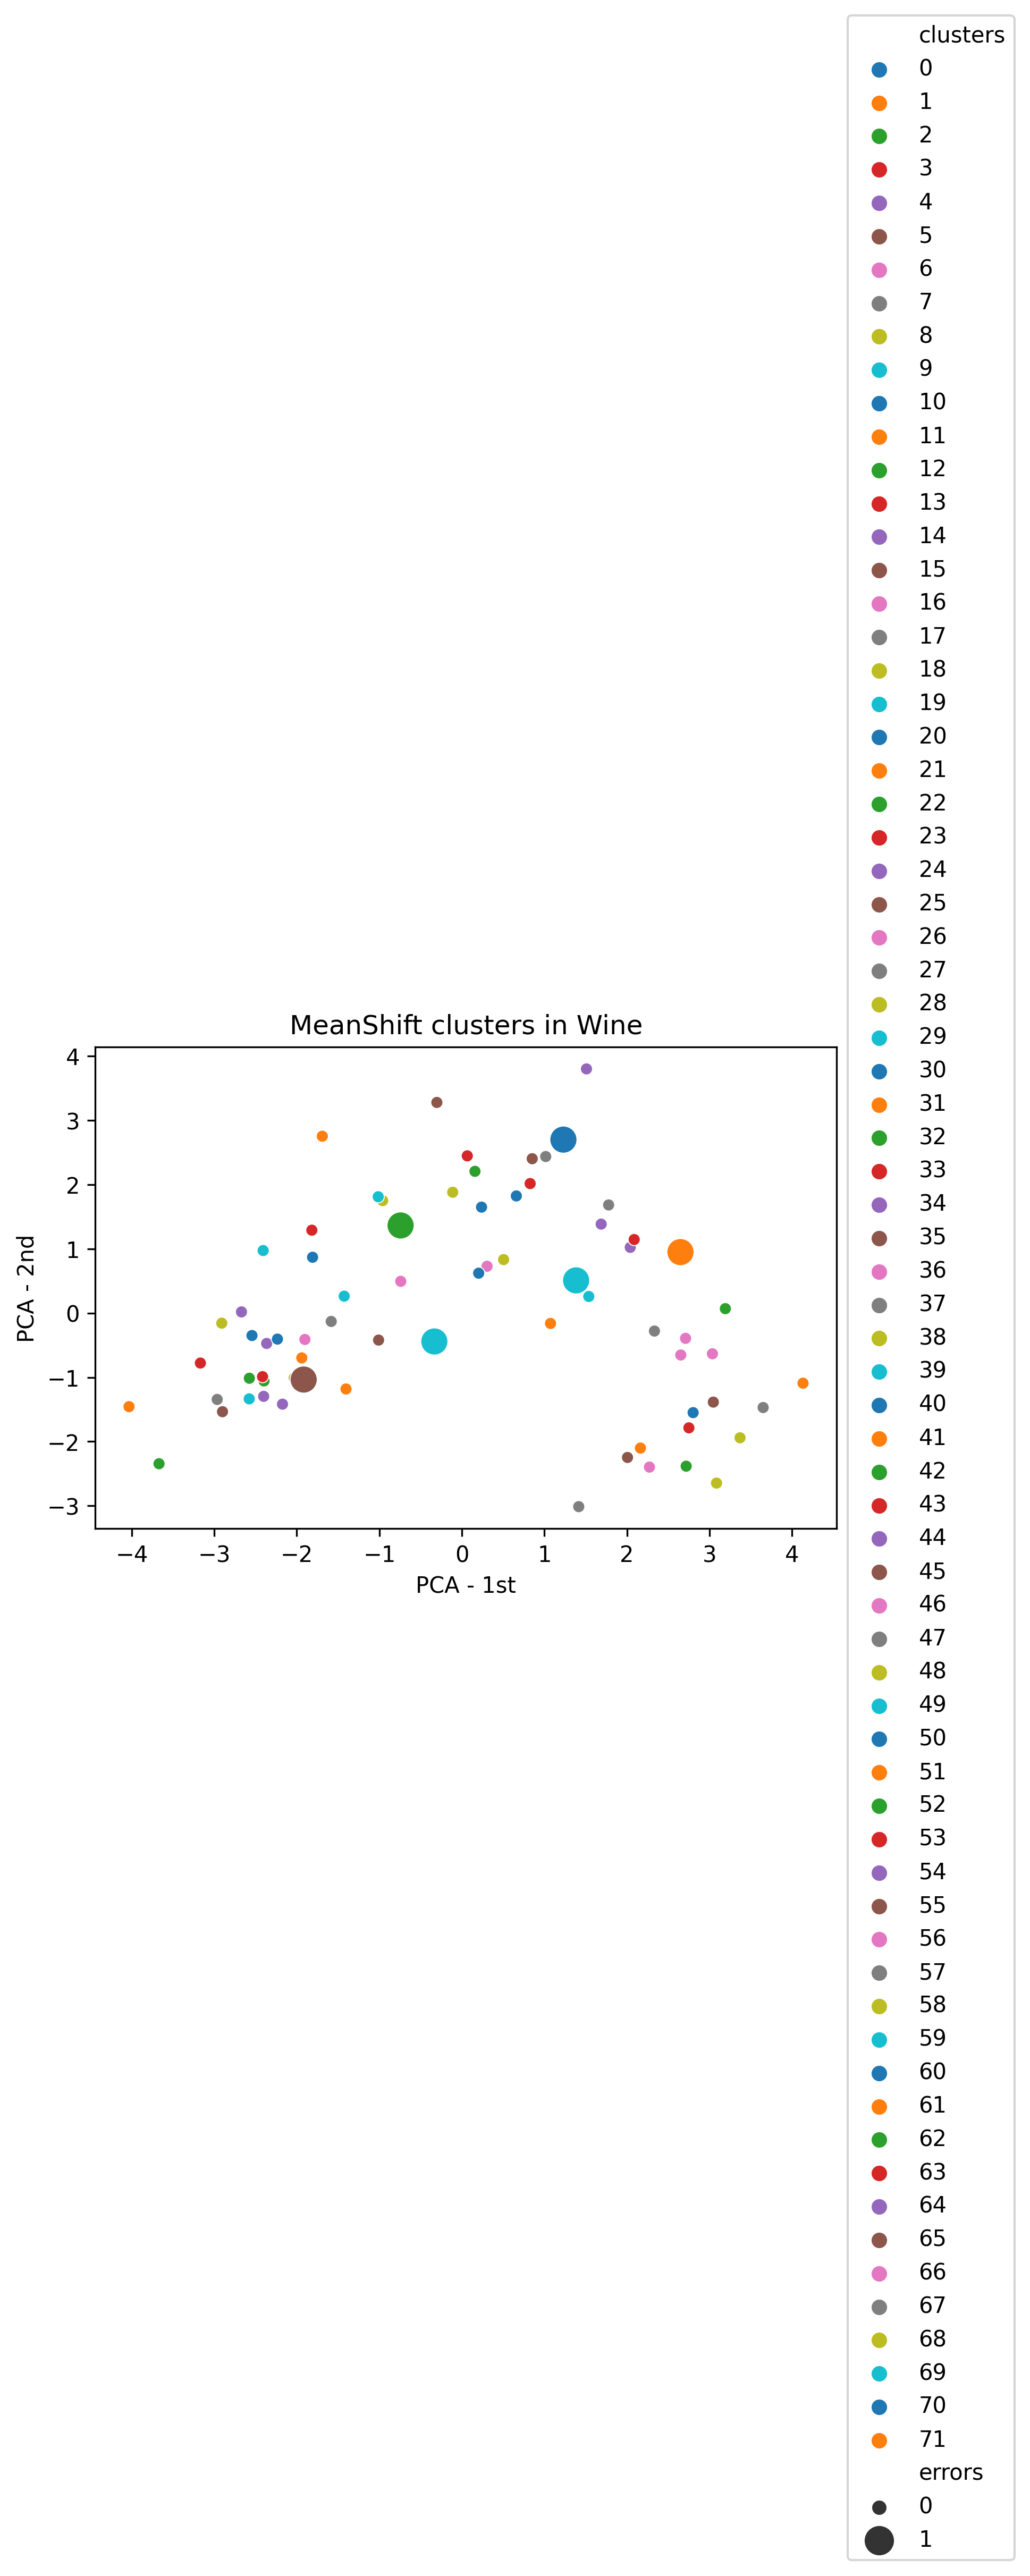

In [87]:
pca_plot(full_data)

In [ ]:
# Goal 1: Identifying highest biased cluster
c = get_max_abs_bias_cluster(full_data)
print(f"cluster {c} has the highest negative bias")
print(full_data['clusters'].unique())
highest_biased_cluster = full_data[full_data['clusters']==c]
len(highest_biased_cluster)

accuracy_full_data = accuracy(full_data)
print('Overall accuracy:', accuracy_full_data)

most_biased_cluster_baselinemeanshift = bias_acc(full_data, c, 'clusters')

full_data[full_data['clusters']==c]
print('Highest found negative bias:', most_biased_cluster_baselinemeanshift)

## Goal 1: Comparing Bias-Aware KMeans/DBSCAN/MeanShift with finding the highest negatively biased cluster

In [ ]:
results_array = []

# the minus is to make the values positive, as that makes it easier to find the highest negative biased cluster
results_array.append(-most_biased_cluster_kmeans_aware)
results_array.append(-most_biased_cluster_dbscan_aware)
results_array.append(-most_biased_cluster_meanshift_aware)
results_array.append(-most_biased_cluster_baselinekm)
results_array.append(-most_biased_cluster_baselinemeanshift)


plt.bar(['KMeans', 'DBSCAN', 'MeanShift', 'BaselineKM', 'BaselineMeanShift'], results_array)
